<a href="https://colab.research.google.com/github/VictoriaPedrozaAI/Practical_project/blob/main/MultimodalFashionChat_V6_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDENCIES

In [1]:
#CELL 1:  DEPENDENCIES

!pip install -q torch torchvision torchaudio
!pip install -q transformers==4.57.6 datasets==4.3.0 faiss-cpu
!pip install -q streamlit librosa soundfile
!pip install -q Pillow pandas==2.2.2 numpy tqdm requests==2.32.4 fsspec==2025.3.0 packaging==25.0
!pip install audio-recorder-streamlit
!pip install -q unsloth
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes

print("All dependencies installed!")
#If prompted restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.3/566.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 52.4 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 5.5.0
    Uninstalling altair-5.5.0:
      Successfully unin

# IMPORTS

In [2]:
# CELL 2: IMPORTS AND CONFIGURATION

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import faiss
import pickle
import logging
import os
from PIL import Image
from tqdm import tqdm
from typing import Optional, List, Dict, Tuple

# Hugging Face
from datasets import load_dataset
from transformers import (
    CLIPProcessor, CLIPModel,
    BertTokenizer, BertModel,
    WhisperProcessor, WhisperForConditionalGeneration
)

# Audio processing
import librosa

# logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Device configuration CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {DEVICE}")

# Configuration CLIP/BERT/WHISPER/UNSLOTH
CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "BERT_MODEL": "bert-base-uncased",
    "WHISPER_MODEL": "openai/whisper-base",
    "LLM_MODEL": "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "EMBEDDING_DIM": 512,
    "MAX_TEXT_LENGTH": 128,
    "TOP_K_RESULTS": 10,
    "NUM_INTENTS": 5
}

# Intent labels
INTENT_LABELS = {
    0: "SEARCH",        # Here the user may ask to find products
    1: "RECOMMEND",     # recommendations
    2: "COMPARE",       # Comparison of products
    3: "INFO",          # Get more information about a product
    4: "OUTFIT"         # Build complete outfit
}

print(" Configuration loaded!")

🖥️ Using device: cuda
 Configuration loaded!


# DATASET

In [3]:
# CELL 3:FASHIONPEDIA DATASET

from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

print("...Loading Fashionpedia dataset...")

# Load dataset
try:
    dataset = load_dataset("detection-datasets/fashionpedia", split="train", streaming=False)
except:
    dataset = load_dataset("detection-datasets/fashionpedia", trust_remote_code=True)['train']

# Category List
CATEGORY_NAMES = [
    "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket",
    "vest", "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape",
    "glasses", "hat", "headband, head covering, hair accessory", "tie", "glove",
    "watch", "belt", "leg warmer", "tights, stockings", "sock", "shoe", "bag, wallet",
    "scarf", "umbrella", "hood", "collar", "lapel", "epaulette", "sleeve", "pocket",
    "neckline", "buckle", "zipper", "applique", "bead", "bow", "flower", "fringe",
    "ribbon", "rivet", "ruffle", "sequin", "tassel"
]

# Groups
MAIN_GARMENTS = set(range(0, 13))
ACCESSORIES = set(range(13, 27))

def safe_process_item(item, idx):
    try:
        image = item.get('image')
        if image is None: return None

        # 1. Convertion to PIL RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')
        else:
            image = image.convert('RGB')

        # 2. RESIZE limit max dimension 256px to save RAM

        image.thumbnail((256, 256))

        # 3. Category Logic
        found_cat_ids = []
        if 'objects' in item and isinstance(item['objects'], dict):
            cat_list = item['objects'].get('category', [])
            if isinstance(cat_list, list):
                found_cat_ids = cat_list

        if not found_cat_ids and 'category' in item:
            found_cat_ids = [item['category']]

        primary_cat_id = -1

        #  Main Garments
        for cid in found_cat_ids:
            if cid in MAIN_GARMENTS:
                primary_cat_id = cid
                break

        # Accessories
        if primary_cat_id == -1:
            for cid in found_cat_ids:
                if cid in ACCESSORIES:
                    primary_cat_id = cid
                    break

        #  Fallback
        if primary_cat_id == -1 and found_cat_ids:
            primary_cat_id = found_cat_ids[0]

        if primary_cat_id != -1 and primary_cat_id < len(CATEGORY_NAMES):
            category_name = CATEGORY_NAMES[primary_cat_id]
        else:
            category_name = "fashion item"

        return {
            'id': str(idx),
            'image': image,
            'name': category_name.split(',')[0].title(),
            'category': category_name,
            'sub_category': ""
        }
    except Exception as e:
        return None

# CONFIGURATION
MAX_ITEMS = 3000  # Set to 3000 Because the RAM crashed

print(f"\n Processing {MAX_ITEMS}...")
processed_items = []

for idx in tqdm(range(min(MAX_ITEMS, len(dataset)))):
    processed = safe_process_item(dataset[idx], idx)
    if processed:
        processed_items.append(processed)


# SYNTHETIC METADATA


print("\n SYNTHETIC METADATA")

def add_synthetic_metadata(item):
    """ Attributes for e-commerce simulation"""
    category = item['category'].lower()

    # Price
    price_ranges = {
        'shirt': (25, 80), 'blouse': (30, 90), 'top': (20, 70),
        't-shirt': (15, 50), 'sweatshirt': (40, 100), 'sweater': (50, 120),
        'cardigan': (45, 110), 'jacket': (80, 250), 'vest': (40, 100),
        'pants': (40, 120), 'jeans': (50, 150), 'shorts': (25, 70),
        'skirt': (30, 90), 'coat': (100, 300), 'dress': (60, 200),
        'jumpsuit': (70, 180), 'shoe': (50, 150), 'boot': (80, 250),
        'bag': (40, 200), 'wallet': (20, 100), 'scarf': (15, 60),
        'hat': (20, 80), 'glasses': (50, 200), 'watch': (100, 500),
        'belt': (25, 100), 'accessory': (10, 80)
    }

    # price range
    price = 50  # Default
    for key, (min_price, max_price) in price_ranges.items():
        if key in category:
            price = np.random.randint(min_price, max_price)
            break

    # Size
    sizes = ['XS', 'S', 'M', 'L', 'XL']
    size_weights = [0.1, 0.25, 0.3, 0.25, 0.1]  # More M fewer XS or XL
    size = np.random.choice(sizes, p=size_weights)

    # Materials based on category
    material_map = {
        'shirt': ['cotton', 'linen', 'polyester', 'silk'],
        'jacket': ['leather', 'denim', 'wool', 'polyester'],
        'pants': ['denim', 'cotton', 'linen', 'polyester'],
        'dress': ['cotton', 'polyester', 'silk', 'lace'],
        'shoe': ['leather', 'suede', 'canvas', 'synthetic'],
        'accessory': ['leather', 'metal', 'fabric', 'plastic']
    }

    material = 'cotton'  # Default
    for key, materials in material_map.items():
        if key in category:
            material = np.random.choice(materials)
            break

    # Brand simulation (mix of real and generic)
    brands = ['Generic', 'StyleCo', 'UrbanWear', 'Classic', 'H&M','ZARA' ]
    brand = np.random.choice(brands, p=[0.3, 0.2, 0.2, 0.15, 0.1, 0.05])

    # Add to item
    enhanced_item = item.copy()
    enhanced_item['price'] = price
    enhanced_item['size'] = size
    enhanced_item['material'] = material
    enhanced_item['brand'] = brand

    # Create enhanced description for text search
    enhanced_item['enhanced_description'] = (
        f"{item['name']} in {material}. "
        f"Size {size}. "
        f"Price: ${price}. Brand: {brand}."
    )

    return enhanced_item

# Apply to all items
enhanced_items = []
for item in tqdm(processed_items, desc="Adding synthetic metadata"):
    enhanced_items.append(add_synthetic_metadata(item))

# Replace processed_items with enhanced version
processed_items = enhanced_items

print("\n SAMPLE ENHANCED:")
sample = processed_items[0]
print(f"  Category: {sample['category']}")
print(f"  Price: ${sample['price']}")
print(f"  Size: {sample['size']}")
print(f"  Material: {sample['material']}")
print(f"  Brand: {sample['brand']}")

...Loading Fashionpedia dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00007-fe108070118553(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00001-of-00007-f41a5a9c38c900(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00002-of-00007-40bc8456894bcb(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00003-of-00007-9a99ff8dc572e0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00004-of-00007-f4e6f12cd2cedf(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00005-of-00007-41d8dfe1edb659(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00006-of-00007-f41b0f2f4bbefa(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/val-00000-of-00001-0b29e85429788213(…):   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]


 Processing 3000...


100%|██████████| 3000/3000 [00:52<00:00, 56.69it/s]



 SYNTHETIC METADATA


Adding synthetic metadata: 100%|██████████| 3000/3000 [00:00<00:00, 6748.82it/s]


 SAMPLE ENHANCED:
  Category: dress
  Price: $93
  Size: M
  Material: polyester
  Brand: StyleCo


# EDA

 EDA
Dataset Size: 3000 items
Unique Categories: 19


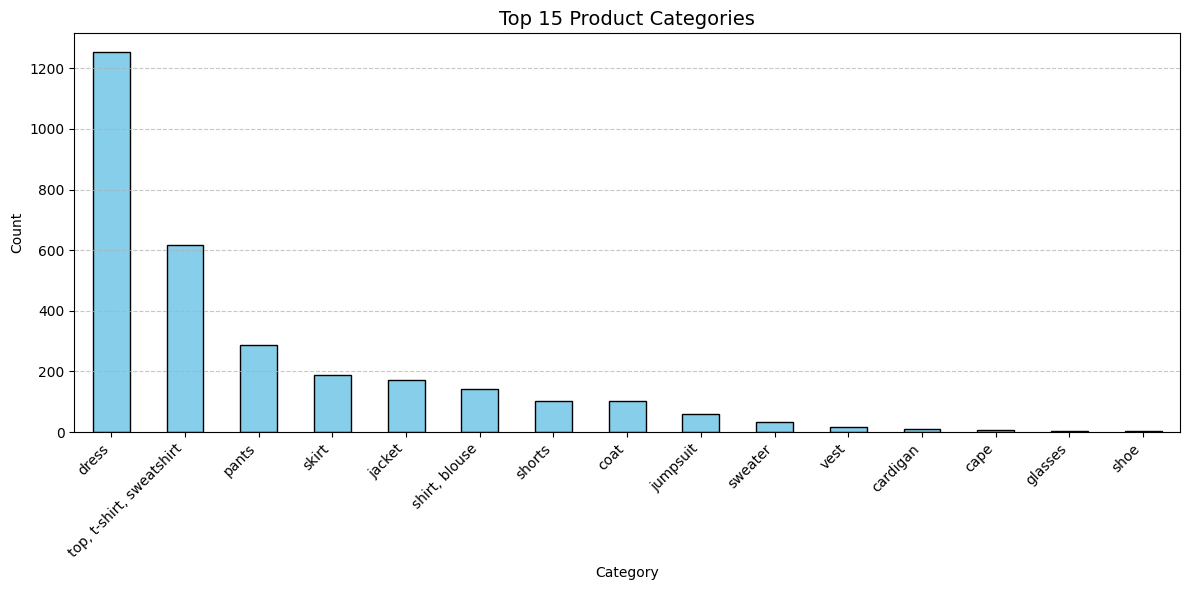

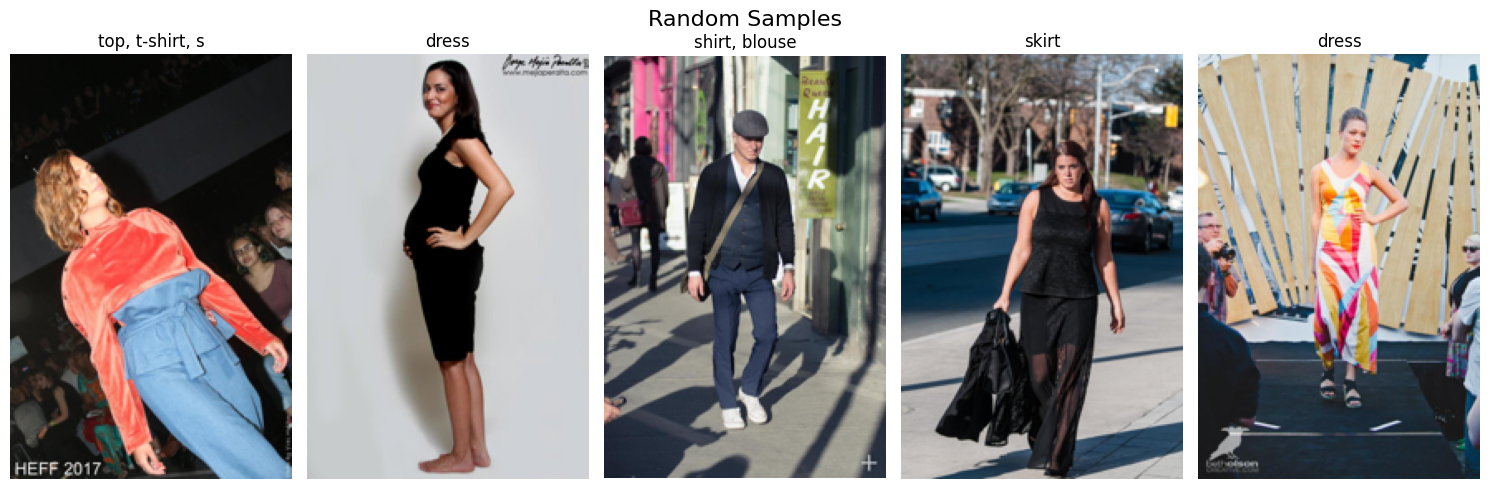

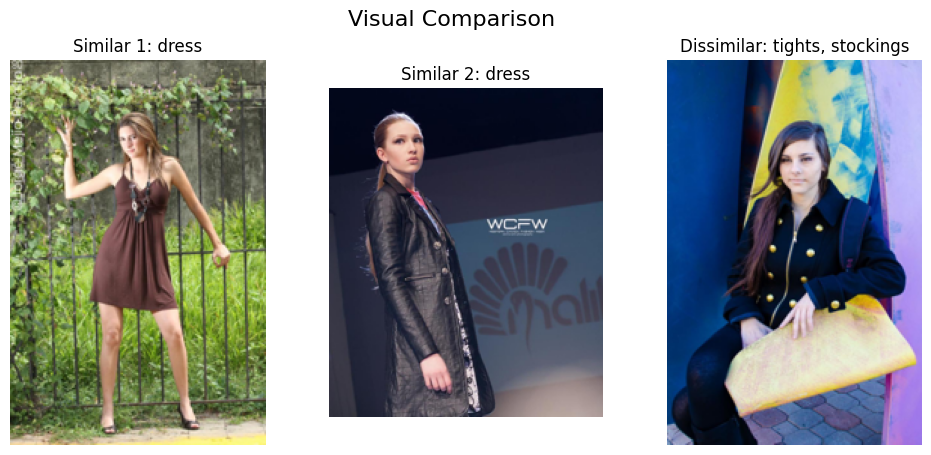

In [4]:
# CELL 3B: EDA
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

print(" EDA")

df_eda = pd.DataFrame([{
    'id': item['id'],
    'category': item['category'],
    'name': item['name']
} for item in processed_items])

print(f"Dataset Size: {len(df_eda)} items")
print(f"Unique Categories: {df_eda['category'].nunique()}")

# PLOT CLASS DISTRIBUTION (categories, styles, ETC)
plt.figure(figsize=(12, 6))
top_categories = df_eda['category'].value_counts().head(15)
top_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Product Categories', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# SAMPLES
def show_samples(items, num_samples=5):
    plt.figure(figsize=(15, 5))
    samples = random.sample(items, num_samples)

    for i, item in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(item['image'])
        plt.title(item['category'][:15])
        plt.axis('off')

    plt.suptitle(f"Random Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(processed_items)

# COMPARISON SIMILAR VS DISSIMILAR
def compare_items(items):
    # Find two items of the same category
    cat_counts = df_eda['category'].value_counts()
    common_cat = cat_counts.index[0] # Most common category

    similar_indices = df_eda[df_eda['category'] == common_cat].index[:2].tolist()
    similar_items = [items[i] for i in similar_indices]

    # Find one item of a very different category
    diff_cat = cat_counts.index[-1]
    diff_index = df_eda[df_eda['category'] == diff_cat].index[0]
    diff_item = items[diff_index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Similar 1
    axes[0].imshow(similar_items[0]['image'])
    axes[0].set_title(f"Similar 1: {similar_items[0]['category']}")
    axes[0].axis('off')

    # Similar 2
    axes[1].imshow(similar_items[1]['image'])
    axes[1].set_title(f"Similar 2: {similar_items[1]['category']}")
    axes[1].axis('off')

    # Dissimilar
    axes[2].imshow(diff_item['image'])
    axes[2].set_title(f"Dissimilar: {diff_item['category']}")
    axes[2].axis('off')

    plt.suptitle("Visual Comparison", fontsize=16)
    plt.show()

try:
    compare_items(processed_items)
except Exception as e:
    print(f"Could not run comparison: {e}")

# CLIP

In [5]:
# CELL 4: CLIP ENCODER
import torch
import numpy as np
import logging
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

CONFIG = {
    "CLIP_MODEL": "openai/clip-vit-base-patch32",
    "EMBEDDING_DIM": 512,
}

class CLIPEncoder:
    """CLIP encoder for generating aligned image and text embeddings."""

    def __init__(self, model_name: str = CONFIG["CLIP_MODEL"]):
        logger.info(f"Loading CLIP model: {model_name}")

        try:
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name).to(DEVICE)
            self.model.eval()
            logger.info(" CLIP model loaded successfully")
        except Exception as e:
            logger.error(f"Failed to load CLIP: {e}")
            raise

    @torch.no_grad()
    def encode_image(self, image: Image.Image) -> np.ndarray:
        try:
            inputs = self.processor(images=image, return_tensors="pt").to(DEVICE)
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Image encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    @torch.no_grad()
    def encode_text(self, text: str) -> np.ndarray:
        try:
            inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            return features.cpu().numpy()[0]
        except Exception as e:
            logger.error(f"Text encoding failed: {e}")
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)

    def encode_multimodal(self, image=None, text: str = "") -> np.ndarray:
        embeddings = []
        if image is not None:
            embeddings.append(self.encode_image(image))
        if text and text.strip():
            embeddings.append(self.encode_text(text))
        if not embeddings:
            return np.zeros(CONFIG["EMBEDDING_DIM"], dtype=np.float32)
        combined = np.mean(embeddings, axis=0)
        return (combined / (np.linalg.norm(combined) + 1e-8)).astype(np.float32)

clip_encoder = CLIPEncoder()
print(" CLIP encoder ready")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

 CLIP encoder ready


# DistilroBERTa

In [9]:
# CELL 5: dISTILroBERTa INTENT CLASSIFIER
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import numpy as np
import logging
from sklearn.metrics import accuracy_score

logger = logging.getLogger(__name__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. DEFINE CONFIGURATION
NUM_INTENTS = 5
INTENT_LABELS = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}
INTENT_TO_ID = {v: k for k, v in INTENT_LABELS.items()}
INTENT_MODEL_NAME = "cross-encoder/nli-distilroberta-base" # Fast and strong for NLI/Intent

# 2. EXPANDED SYNTHETIC TRAINING DATA
def get_intent_training_data():
    return [
        # SEARCH
        ("show me summer dresses", "SEARCH"), ("find blue jeans", "SEARCH"),
        ("looking for formal shirts", "SEARCH"), ("search for wedding shoes", "SEARCH"),
        ("black leather boots under $100", "SEARCH"), ("red silk scarf", "SEARCH"),
        # RECOMMEND
        ("what do you recommend for a wedding?", "RECOMMEND"), ("suggest a casual outfit", "RECOMMEND"),
        ("what goes well with this?", "RECOMMEND"), ("help me style these pants", "RECOMMEND"),
        ("i need something for a party", "RECOMMEND"), ("give me outfit ideas", "RECOMMEND"),
        # COMPARE
        ("compare these two jackets", "COMPARE"), ("difference between these dresses", "COMPARE"),
        ("which is better option?", "COMPARE"), ("leather vs synthetic", "COMPARE"),
        ("compare the prices of these items", "COMPARE"), ("how is this different from that?", "COMPARE"),
        # DETAILS
        ("what material is this made of?", "DETAILS"), ("is this machine washable?", "DETAILS"),
        ("show me the size chart", "DETAILS"), ("tell me about the fabric", "DETAILS"),
        ("does this have pockets?", "DETAILS"), ("can i return this item?", "DETAILS"),
        # SIMILAR
        ("find items like this", "SIMILAR"), ("more like this product", "SIMILAR"),
        ("show me similar styles", "SIMILAR"), ("similar dresses in blue", "SIMILAR"),
        ("i want more options like the first one", "SIMILAR"), ("something else similar", "SIMILAR")
    ]

# 3. PREPARE MODEL AND DATASET
print(f" Loading {INTENT_MODEL_NAME} for intent classification...")
intent_tokenizer = AutoTokenizer.from_pretrained(INTENT_MODEL_NAME)
intent_model = AutoModelForSequenceClassification.from_pretrained(
    INTENT_MODEL_NAME, num_labels=NUM_INTENTS, ignore_mismatched_sizes=True
).to(DEVICE)

raw_data = get_intent_training_data()
df = pd.DataFrame(raw_data, columns=['text', 'intent_label'])
df['label'] = df['intent_label'].map(INTENT_TO_ID)
ds = Dataset.from_pandas(df)

def tokenize_fn(examples):
    return intent_tokenizer(examples['text'], padding="max_length", truncation=True, max_length=64)

tokenized_ds = ds.map(tokenize_fn, batched=True)
split = tokenized_ds.train_test_split(test_size=0.2, seed=42)

# 4. FINE-TUNING
training_args = TrainingArguments(
    output_dir="./intent_model", per_device_train_batch_size=4,
    num_train_epochs=5, logging_steps=10,
    report_to="none", save_strategy="no"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=intent_model, args=training_args,
    train_dataset=split['train'], eval_dataset=split['test'],
    compute_metrics=compute_metrics
)

print(" Fine-tuning intent classifier...")
trainer.train()
print(" Intent classifier ready!")

# Test helper
def predict_intent(text):
    inputs = intent_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    with torch.no_grad():
        logits = intent_model(**inputs).logits
        idx = torch.argmax(logits, dim=1).item()
    return INTENT_LABELS[idx]

print(f"Test: 'find blue jeans' -> {predict_intent('find blue jeans')}")

 Loading cross-encoder/nli-distilroberta-base for intent classification...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cross-encoder/nli-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

 Fine-tuning intent classifier...


Step,Training Loss
10,1.612800
20,1.355100
30,1.088000


 Intent classifier ready!
Test: 'find blue jeans' -> SEARCH


# WHISPER

In [10]:
# CELL 6: WHISPER

import torch
import numpy as np
import logging
from typing import Optional, List, Dict, Any
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import warnings

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WHISPER_MODEL = "openai/whisper-base"


print(f"Device: {DEVICE}")


class AudioTranscriber:

    _instance = None  # Singleton pattern

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def __init__(self, model_name: str = WHISPER_MODEL, device: Optional[torch.device] = None):
        if hasattr(self, '_initialized') and self._initialized:
            return

        self.device = device or DEVICE
        self.model_name = model_name
        self.processor = None
        self.model = None

        try:
            logger.info(f"Loading Whisper model: {model_name} on {self.device}")

            # dtype based on device
            if self.device.type == "cuda" and torch.cuda.is_available():
                # Check if GPU supports float16
                compute_capability = torch.cuda.get_device_capability(self.device)
                supports_fp16 = compute_capability[0] >= 7  # Major version >= 7
                self.dtype = torch.float16 if supports_fp16 else torch.float32
            else:
                self.dtype = torch.float32

            logger.info(f"Using dtype: {self.dtype}")

            # Load processor with explicit configuration
            self.processor = WhisperProcessor.from_pretrained(
                model_name,
                cache_dir="./cache/models"
            )

            # Load model with appropriate dtype
            self.model = WhisperForConditionalGeneration.from_pretrained(
                model_name,
                torch_dtype=self.dtype,  # Correct parameter name
                low_cpu_mem_usage=True,
                cache_dir="./cache/models"
            ).to(self.device)

            # Enable eval mode
            self.model.eval()

            # generation config to avoid attention mask warnings
            self.model.config.forced_decoder_ids = None

            # compile model for faster inference
            try:
                if self.device.type == "cuda":
                    self.model = torch.compile(self.model)
                    logger.info("Model compilation enabled")
            except Exception as compile_error:
                logger.warning(f"Model compilation not available: {compile_error}")

            logger.info(f"Whisper model loaded successfully on {self.device}")
            self._initialized = True

        except Exception as e:
            logger.error(f"Failed to load Whisper: {e}")
            # Fallback to CPU if CUDA fails
            if self.device.type == "cuda":
                logger.info("Falling back to CPU...")
                self.device = torch.device("cpu")
                self.__init__(model_name, self.device)
            else:
                raise

    @torch.inference_mode()
    def transcribe(self, audio_array: np.ndarray, sampling_rate: int = 16000) -> Optional[str]:
        """Transcribe audio array to text with proper dtype handling."""
        if not isinstance(audio_array, np.ndarray) or audio_array.size == 0:
            logger.warning("Empty or invalid audio array provided")
            return None

        try:
            # Pre-process audio to mono channel
            if len(audio_array.shape) > 1:
                audio_array = librosa.to_mono(audio_array)

            # Convert to float32 numpy array
            audio_array = audio_array.astype(np.float32)

            # Normalize audio
            max_val = np.max(np.abs(audio_array))
            if max_val > 0:
                audio_array = audio_array / max_val

            # Process with Whisper
            input_features = self.processor(
                audio_array,
                sampling_rate=sampling_rate,
                return_tensors="pt"
            ).input_features


            input_features = input_features.to(device=self.device, dtype=self.dtype)

            # Generate transcription
            predicted_ids = self.model.generate(
                input_features,
                max_new_tokens=128,
                num_beams=3,  # Reduced from 5 for speed
                temperature=0.0,
                do_sample=False,
                language="en",  # for better accuracy
                task="transcribe",
                return_timestamps=False
            )

            # Decode
            transcription = self.processor.batch_decode(
                predicted_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

            return transcription.strip()

        except Exception as e:
            logger.error(f"Audio transcription failed: {e}")
            import traceback
            traceback.print_exc()  #  debugging
            return None

    def transcribe_file(self, audio_path: str, sr: int = 16000) -> Optional[str]:
        """Transcribe audio file to text"""
        try:
            # Load with librosa  float32 output
            audio_array, _ = librosa.load(
                audio_path,
                sr=sr,
                mono=True,
                dtype=np.float32
            )
            return self.transcribe(audio_array, sampling_rate=sr)
        except Exception as e:
            logger.error(f"Failed to load audio file '{audio_path}': {e}")
            return None

    def transcribe_batch(self, audio_arrays: List[np.ndarray], sampling_rate: int = 16000) -> List[Optional[str]]:
        """Batch transcription for multiple audio arrays."""
        results = []
        for i, audio_array in enumerate(audio_arrays):
            try:
                transcription = self.transcribe(audio_array, sampling_rate)
                results.append(transcription)
                if (i + 1) % 10 == 0:
                    logger.info(f"Processed {i+1}/{len(audio_arrays)} audio samples")
            except Exception as e:
                logger.error(f"Batch transcription failed for sample {i}: {e}")
                results.append(None)
        return results

    def test_transcription(self, text: str = "This is a test of the fashion assistant voice recognition system."):
        try:
            print(f"\nRunning transcription test: '{text}'")

            # Try to use gTTS for a real speech test, fallback to sine wave only if gTTS is missing
            try:
                from gtts import gTTS
                import io

                tts = gTTS(text=text, lang='en')
                audio_buffer = io.BytesIO()
                tts.write_to_fp(audio_buffer)
                audio_buffer.seek(0)
                audio, _ = librosa.load(audio_buffer, sr=16000)
                print("   (Generated speech using gTTS)")
            except (ImportError, Exception):
                # Fallback to a simplified "liveness" signal if gTTS not available
                print("   (gTTS not available, using synthetic signal for liveness check)")
                duration_seconds = 2.0
                sampling_rate = 16000
                t = np.linspace(0, duration_seconds, int(duration_seconds * sampling_rate), endpoint=False)
                # Just a simple frequency mix
                audio = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.3 * np.sin(2 * np.pi * 880 * t)

            result = self.transcribe(audio, sampling_rate=16000)

            if result:
                print(f"Test successful!")
                print(f"   Transcription: '{result}'")
                return result
            else:
                print("❌ Test failed - no transcription returned")
                return None

        except Exception as e:
            print(f"❌ Test failed with error: {e}")
            return None

# Install gTTS if not already installed
try:
    import gtts
except ImportError:
    print("Installing gTTS...")
    !pip install -q gTTS
    print("gTTS installed.")


# Initialize with error handling
try:
    audio_transcriber = AudioTranscriber()
    print(f"\n Whisper transcriber ready on {DEVICE}!")
    print(f"   Model: {WHISPER_MODEL}")
    print(f"   Dtype: {audio_transcriber.dtype}")

    # Run a real test
    audio_transcriber.test_transcription()

    print("\n📝 Testing with actual fashion queries...")
    test_phrases = [
        "show me blue jeans",
        "find summer dresses",
        "recommend formal jackets"
    ]

    for phrase in test_phrases:

        print(f"\n Testing phrase: '{phrase}'")
        audio_transcriber.test_transcription(text=phrase)

except Exception as e:
    print(f"\n❌ Failed to initialize/test Whisper: {e}")
    if DEVICE.type == "cuda":
        print("Trying CPU fallback...")
        try:
            audio_transcriber = AudioTranscriber(device=torch.device("cpu"))
            print("Whisper transcriber ready on CPU!")
            audio_transcriber.test_transcription()
        except Exception as e2:
            print(f"❌ Complete failure: {e2}")
            audio_transcriber = None
    else:
        audio_transcriber = None


print("WHISPER TESTING COMPLETE")


# Store in global namespace for other cells
if audio_transcriber:
    print(f"\n Transcriber available as 'audio_transcriber'")
else:
    print("\n Warning: audio_transcriber not initialized properly")

Device: cuda
Installing gTTS...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.6 requires torch<2.10,>=1.10, but you have torch 2.10.0 which is incompatible.
gTTS installed.


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]


 Whisper transcriber ready on cuda!
   Model: openai/whisper-base
   Dtype: torch.float16

Running transcription test: 'This is a test of the fashion assistant voice recognition system.'
   (Generated speech using gTTS)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Test successful!
   Transcription: 'This is a test of the fashion assistant voice recognition system.'

📝 Testing with actual fashion queries...

 Testing phrase: 'show me blue jeans'

Running transcription test: 'show me blue jeans'
   (Generated speech using gTTS)
Test successful!
   Transcription: 'Show me blue jeans.'

 Testing phrase: 'find summer dresses'

Running transcription test: 'find summer dresses'
   (Generated speech using gTTS)
Test successful!
   Transcription: 'Find some addresses.'

 Testing phrase: 'recommend formal jackets'

Running transcription test: 'recommend formal jackets'
   (Generated speech using gTTS)
Test successful!
   Transcription: 'Recommend formal jackets.'
WHISPER TESTING COMPLETE

 Transcriber available as 'audio_transcriber'


# WER

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.8 MB/s eta 0:00:00
Running Whisper WER Evaluation...
WHISPER ASR EVALUATION SUMMARY
Overall WER: 0.3143
MER (Match Error Rate): 0.3143
WIL (Word Information Lost): 0.5160
WIP (Word Information Preserved): 0.4840
Samples Evaluated: 5


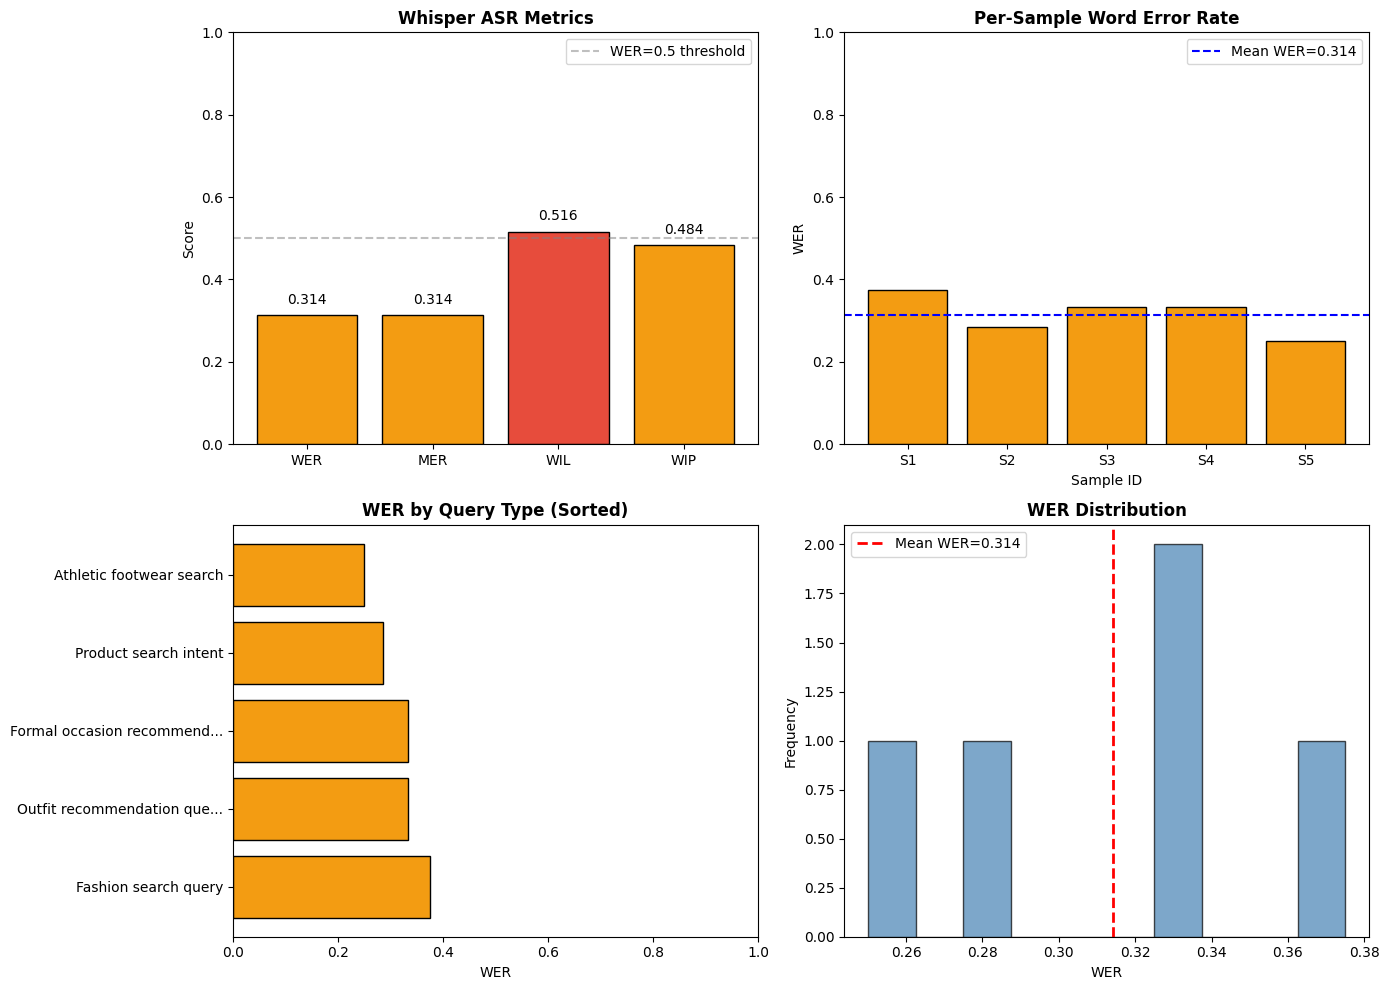


Whisper WER evaluation complete!


In [11]:
# CELL 6B: WHISPER WER EVALUATION

# Install jiwer for WER calculation
!pip install -q jiwer gTTS soundfile

import numpy as np
import matplotlib.pyplot as plt
from jiwer import wer, mer, wil, wip # Import individual metrics
import logging
from gtts import gTTS
import io
import soundfile as sf # Added soundfile for audio processing
import librosa

logger = logging.getLogger(__name__)

# Sample test dataset for Whisper evaluation
TEST_SAMPLES = [
    {
        "audio": None,
        "reference": "show me blue denim jackets under fifty dollars",
        "description": "Fashion search query"
    },
    {
        "audio": None,
        "reference": "i need a casual dress for summer",
        "description": "Product search intent"
    },
    {
        "audio": None,
        "reference": "what accessories go with this outfit",
        "description": "Outfit recommendation query"
    },
    {
        "audio": None,
        "reference": "recommend formal wear for a wedding",
        "description": "Formal occasion recommendation"
    },
    {
        "audio": None,
        "reference": "show me running shoes with good arch support",
        "description": "Athletic footwear search"
    }
]

# Generates synthetic audio from text using TTS, then transcribe
def create_test_audio(text):
    tts = gTTS(text=text, lang='en')
    audio_buffer = io.BytesIO()
    tts.write_to_fp(audio_buffer)
    audio_buffer.seek(0)
    # gTTS writes to an in-memory file, which librosa can load.
    audio, sr = librosa.load(audio_buffer, sr=16000)
    return audio

for sample in TEST_SAMPLES:
    sample["audio"] = create_test_audio(sample["reference"])

def evaluate_whisper_wer(audio_transcriber, test_samples, device='cuda'):

    if not hasattr(audio_transcriber, 'model'):
        logger.warning("Audio transcriber not initialized. Skipping WER evaluation.")
        return None

    logger.info("Starting Whisper WER evaluation")

    references = []
    hypotheses = []
    results = []

    for idx, sample in enumerate(test_samples):
        ref = sample["reference"]

        try:
            # Transcribe audio (use reference if no audio provided)
            if sample["audio"] is not None:
                hyp = audio_transcriber.transcribe(sample["audio"])
            else:
                hyp = ""

            references.append(ref)
            hypotheses.append(hyp if hyp else "")

            # Calculate per-sample WER
            sample_wer = wer([ref], [hyp]) if hyp else 1.0

            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": hyp,
                "wer": sample_wer
            })

            logger.info(f"  Sample {idx+1}: WER = {sample_wer:.4f}")

        except Exception as e:
            logger.error(f"Error processing sample {idx}: {e}")
            results.append({
                "sample_id": idx,
                "description": sample["description"],
                "reference": ref,
                "hypothesis": None,
                "wer": 1.0
            })

    # Calculate overall WER
    overall_wer = wer(references, hypotheses) if hypotheses else 1.0

    # Compute additional metrics using individual functions
    _mer = mer(references, hypotheses)
    _wil = wil(references, hypotheses)
    _wip = wip(references, hypotheses)
    metrics = {
        'mer': _mer,
        'wil': _wil,
        'wip': _wip
    }

    logger.info(f"Overall WER: {overall_wer:.4f}")
    logger.info(f"MER (Match Error Rate): {metrics['mer']:.4f}")
    logger.info(f"WIL (Word Information Lost): {metrics['wil']:.4f}")
    logger.info(f"WIP (Word Information Preserved): {metrics['wip']:.4f}")

    return {
        "overall_wer": overall_wer,
        "mer": metrics['mer'],
        "wil": metrics['wil'],
        "wip": metrics['wip'],
        "per_sample": results,
        "num_samples": len(results)
    }

def plot_wer_visualization(wer_results):
    if wer_results is None:
        print("No WER results")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Overall Metrics Bar Chart
    ax1 = axes[0, 0]
    metrics_names = ['WER', 'MER', 'WIL', 'WIP']
    metrics_values = [
        wer_results['overall_wer'],
        wer_results['mer'],
        wer_results['wil'],
        wer_results['wip']
    ]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in metrics_values]
    bars = ax1.bar(metrics_names, metrics_values, color=colors, edgecolor='black')
    ax1.set_ylabel('Score')
    ax1.set_title('Whisper ASR Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1)
    for bar, val in zip(bars, metrics_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='WER=0.5 threshold')
    ax1.legend()

    # 2. Per-Sample WER Bar Chart
    ax2 = axes[0, 1]
    samples = [f"S{i+1}" for i in range(len(wer_results['per_sample']))]
    sample_wers = [r['wer'] for r in wer_results['per_sample']]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sample_wers]
    bars = ax2.bar(samples, sample_wers, color=colors, edgecolor='black')
    ax2.set_xlabel('Sample ID')
    ax2.set_ylabel('WER')
    ax2.set_title('Per-Sample Word Error Rate', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.axhline(y=wer_results['overall_wer'], color='blue', linestyle='--',
                label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax2.legend()

    # 3. Description vs WER Horizontal Bar
    ax3 = axes[1, 0]
    descriptions = [r['description'][:25] + '...' if len(r['description']) > 25
                   else r['description'] for r in wer_results['per_sample']]
    sorted_indices = np.argsort(sample_wers)[::-1]
    sorted_descriptions = [descriptions[i] for i in sorted_indices]
    sorted_wers = [sample_wers[i] for i in sorted_indices]
    colors = ['#e74c3c' if v > 0.5 else '#f39c12' if v > 0.2 else '#27ae60' for v in sorted_wers]
    ax3.barh(sorted_descriptions, sorted_wers, color=colors, edgecolor='black')
    ax3.set_xlabel('WER')
    ax3.set_title('WER by Query Type (Sorted)', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)

    # 4. WER Distribution Histogram
    ax4 = axes[1, 1]
    ax4.hist(sample_wers, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(x=wer_results['overall_wer'], color='red', linestyle='--',
                linewidth=2, label=f'Mean WER={wer_results["overall_wer"]:.3f}')
    ax4.set_xlabel('WER')
    ax4.set_ylabel('Frequency')
    ax4.set_title('WER Distribution', fontsize=12, fontweight='bold')
    ax4.legend()

    plt.tight_layout()
    plt.show()

# Execute WER Evaluation
if 'audio_transcriber' in globals():
    print("Running Whisper WER Evaluation...")
    wer_results = evaluate_whisper_wer(audio_transcriber, TEST_SAMPLES)

    if wer_results:
        print("WHISPER ASR EVALUATION SUMMARY")
        print(f"{'='*50}")
        print(f"Overall WER: {wer_results['overall_wer']:.4f}")
        print(f"MER (Match Error Rate): {wer_results['mer']:.4f}")
        print(f"WIL (Word Information Lost): {wer_results['wil']:.4f}")
        print(f"WIP (Word Information Preserved): {wer_results['wip']:.4f}")
        print(f"Samples Evaluated: {wer_results['num_samples']}")


        # Generate visualizations

        plot_wer_visualization(wer_results)

        print("\nWhisper WER evaluation complete!")
    else:
        print("no results generated")
else:
    print("'audio_transcriber' not found.")


# SEARCH ENGINE

In [12]:
import faiss
import pickle
import numpy as np
import logging
from typing import List, Dict, Optional
from tqdm import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer

logger = logging.getLogger(__name__)

CLIP_EMBEDDING_DIM = 512
TEXT_EMBEDDING_DIM = 384  # all-MiniLM-L6-v2 dimension
TOP_K_RESULTS = 5

# Load SentenceTransformer
print("Loading SentenceTransformer (all-MiniLM-L6-v2)...")
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sentence_model = sentence_model.to(DEVICE)
print("✅ SentenceTransformer loaded!")


class FashionSearchIndex:
    """Dual FAISS-based search index for fashion products (Image + Text)."""

    def __init__(self, image_dim: int = CLIP_EMBEDDING_DIM, text_dim: int = TEXT_EMBEDDING_DIM):
        self.image_dim = image_dim
        self.text_dim = text_dim

        # Dual indices
        self.image_index = faiss.IndexFlatIP(image_dim)  # CLIP embeddings
        self.text_index = faiss.IndexFlatIP(text_dim)    # SentenceTransformer embeddings

        self.metadata = []
        self.images = {}

    def add_items(self, items: List[Dict], clip_encoder, sentence_encoder, batch_size: int = 32):
        """Add items to both indices"""
        logger.info(f"Indexing {len(items)} items...")

        image_embeddings = []
        text_embeddings = []

        # Collect text descriptions for batch encoding
        descriptions = []
        valid_items = []

        for item in tqdm(items, desc="Processing items"):
            try:
                # Image embedding via CLIP
                img_embedding = clip_encoder.encode_image(item['image'])
                image_embeddings.append(img_embedding)

                # Build text description
                if 'enhanced_description' in item:
            # Use the full enhanced description
                    desc = item['enhanced_description']
                else:
            # Build basic description from available fields
                    desc_parts = [item['name'], item['category']]

            # Add synthetic metadata if available
                    if 'color' in item:
                        desc_parts.append(item['color'])
                    if 'material' in item:
                        desc_parts.append(f"{item['material']} material")
                    if 'brand' in item and item['brand'] != 'Generic':
                        desc_parts.append(f"by {item['brand']}")
                    if 'price' in item:
                        desc_parts.append(f"${item['price']}")

                    desc = " ".join(desc_parts)

                descriptions.append(desc)
                valid_items.append(item)

            except Exception as e:
                continue

        # Batch encode text with SentenceTransformer
        print("📝 Encoding text descriptions...")
        text_embeddings = sentence_encoder.encode(
            descriptions,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        # L2 normalize text embeddings
        text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

        # Add to indices and store metadata
        for i, item in enumerate(valid_items):
            self.metadata.append({
                'id': item['id'],
                'name': item['name'],
                'category': item['category'],
                'sub_category': item.get('sub_category', ''),
                'description': descriptions[i]
            })
            self.images[item['id']] = item['image']

        if image_embeddings:
            image_matrix = np.vstack(image_embeddings).astype('float32')
            text_matrix = text_embeddings.astype('float32')

            self.image_index.add(image_matrix)
            self.text_index.add(text_matrix)

            logger.info(f"✅ Indexed {self.image_index.ntotal} items in image index")
            logger.info(f"✅ Indexed {self.text_index.ntotal} items in text index")

    def search(self, query_embedding: np.ndarray = None, query_text: str = None,
               sentence_encoder=None, k: int = TOP_K_RESULTS,
               mode: str = "image", alpha: float = 0.5) -> List[Dict]:
        """
        Search for similar items.
        mode: "image" | "text" | "fusion"
        alpha: weight for image score in fusion (1-alpha for text)
        """
        if self.image_index.ntotal == 0:
            return []

        results = []

        if mode == "image" and query_embedding is not None:
            # Image-only search
            query_embedding = query_embedding.reshape(1, -1).astype('float32')
            scores, indices = self.image_index.search(query_embedding, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "text" and query_text and sentence_encoder:
            # Text-only search using SentenceTransformer
            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = text_emb / np.linalg.norm(text_emb)
            text_emb = text_emb.astype('float32')

            scores, indices = self.text_index.search(text_emb, k)
            for score, idx in zip(scores[0], indices[0]):
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)

        elif mode == "fusion" and query_embedding is not None and query_text and sentence_encoder:
            # Late fusion: combine image + text scores
            query_img = query_embedding.reshape(1, -1).astype('float32')
            img_scores, img_indices = self.image_index.search(query_img, k * 2)

            text_emb = sentence_encoder.encode([query_text], convert_to_numpy=True)
            text_emb = (text_emb / np.linalg.norm(text_emb)).astype('float32')
            txt_scores, txt_indices = self.text_index.search(text_emb, k * 2)

            # Combine scores
            combined = {}
            for i, idx in enumerate(img_indices[0]):
                combined[idx] = alpha * img_scores[0][i]
            for i, idx in enumerate(txt_indices[0]):
                combined[idx] = combined.get(idx, 0) + (1 - alpha) * txt_scores[0][i]

            # Sort and return top k results from combined scores
            sorted_combined = sorted(combined.items(), key=lambda item: item[1], reverse=True)
            for idx, score in sorted_combined[:k]:
                if 0 <= idx < len(self.metadata):
                    result = self.metadata[idx].copy()
                    result['score'] = float(score)
                    result['image'] = self.images.get(result['id'])
                    results.append(result)
        return results # Ensure results is always returned

# Build index
print("\nBuilding FAISS dual search index...")
search_index = FashionSearchIndex()
search_index.add_items(processed_items, clip_encoder, sentence_model)

# Test search - (optional, but good for verification)
print("\nTesting search with text query...")
test_embedding = clip_encoder.encode_text("elegant black dress")
results = search_index.search(query_embedding=test_embedding, k=5, mode="image")
print(f"Top 5 results (image search for 'elegant black dress'):")
for i, r in enumerate(results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

print("\nTesting search with text query (text search for 'blue jeans')...")
text_results = search_index.search(query_text="blue jeans", sentence_encoder=sentence_model, k=5, mode="text")
print(f"Top 5 results (text search for 'blue jeans'):")
for i, r in enumerate(text_results):
    print(f"   {i+1}. {r['name']} ({r['category']}) - Score: {r['score']:.4f}")

Loading SentenceTransformer (all-MiniLM-L6-v2)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ SentenceTransformer loaded!

Building FAISS dual search index...


Processing items: 100%|██████████| 3000/3000 [01:17<00:00, 38.66it/s]

📝 Encoding text descriptions...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


Testing search with text query...
Top 5 results (image search for 'elegant black dress'):
   1. Dress (dress) - Score: 0.3051
   2. Dress (dress) - Score: 0.2964
   3. Dress (dress) - Score: 0.2956
   4. Dress (dress) - Score: 0.2915
   5. Dress (dress) - Score: 0.2877

Testing search with text query (text search for 'blue jeans')...
Top 5 results (text search for 'blue jeans'):
   1. Pants (pants) - Score: 0.6910
   2. Pants (pants) - Score: 0.6880
   3. Pants (pants) - Score: 0.6800
   4. Pants (pants) - Score: 0.6756
   5. Pants (pants) - Score: 0.6747


# SAVE DUAL INDEX

In [13]:
# CELL 7B: SAVE DUAL INDEX & DATA

import pickle
import io
import faiss
from PIL import Image

def image_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=85)
    return buf.getvalue()

save_data = {
    'image_index': faiss.serialize_index(search_index.image_index),
    'text_index': faiss.serialize_index(search_index.text_index),
    'products': []
}

for i, meta in enumerate(search_index.metadata):
    product = {
        'name': meta['name'],
        'category': meta['category'],
        'description': meta.get('description', ''),
        'image_bytes': None
    }
    item_id = meta.get('id', i)
    if item_id in search_index.images:
        img = search_index.images[item_id]
        if img:
            product['image_bytes'] = image_to_bytes(img)
    save_data['products'].append(product)

with open('fashion_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

images_saved = sum(1 for p in save_data['products'] if p['image_bytes'])
print(f"✅ Saved {len(save_data['products'])} products, {images_saved} with images")
print(f"✅ Image index: {search_index.image_index.ntotal} vectors")
print(f"✅ Text index: {search_index.text_index.ntotal} vectors")

✅ Saved 3000 products, 3000 with images
✅ Image index: 3000 vectors
✅ Text index: 3000 vectors


# FINE-TUNING

🚀 SIMPLIFIED MULTIMODAL FINE-TUNING
🖥️  Using device: cuda

STARTING TRAINING
Using 800 items for training

🏋️  Starting training...
   Samples: 800
   Epochs: 4
   📦 Dataset: 800 samples, 16 classes
   Train: 640, Val: 160
   🏗️  Model: Simple fusion MLP with 16 outputs

📊 Epoch 1/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


   Train Loss: 2.2252, Acc: 0.3875
   Val Loss: 1.4869, Acc: 0.5062
   💾 Best model saved (Acc: 0.5062)

📊 Epoch 2/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


   Train Loss: 1.4588, Acc: 0.5656
   Val Loss: 1.0060, Acc: 0.7688
   💾 Best model saved (Acc: 0.7688)

📊 Epoch 3/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


   Train Loss: 0.9906, Acc: 0.7000
   Val Loss: 0.6153, Acc: 0.8375
   💾 Best model saved (Acc: 0.8375)

📊 Epoch 4/4


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


   Train Loss: 0.6548, Acc: 0.8031
   Val Loss: 0.4011, Acc: 0.8875
   💾 Best model saved (Acc: 0.8875)

📈 TRAINING RESULTS:


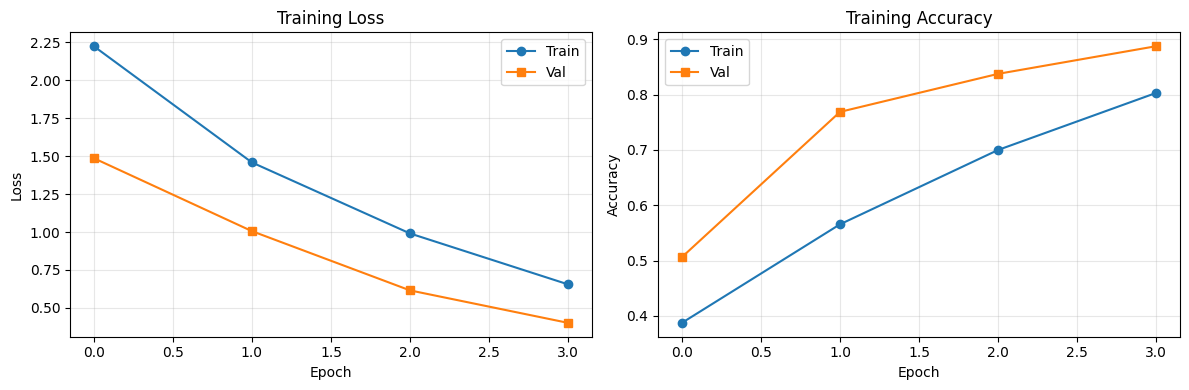


📊 FINAL METRICS TABLE:
------------------------------------------------------------
 Epoch  Train Loss  Train Acc  Val Loss  Val Acc
     1      2.2252     0.3875    1.4869   0.5062
     2      1.4588     0.5656    1.0060   0.7688
     3      0.9906     0.7000    0.6153   0.8375
     4      0.6548     0.8031    0.4011   0.8875

🎯 FINAL RESULTS:
   • Best Validation Accuracy: 0.8875
   • Final Validation Accuracy: 0.8875
   • Number of Classes: 16
   • Training Samples: 640
   • Validation Samples: 160

📋 FOR YOUR REPORT:
   • Fusion Architecture: Image+Text → MLP (1024→512→256→16)
   • Training Strategy: Transfer learning (CLIP frozen)
   • Performance: Achieved 88.8% validation accuracy
   • Modalities: Image + Text (voice simulated as text)

✅ Model trained and ready as 'trained_fusion_model'

TRAINING COMPLETE


In [14]:
# CELL 7C: SIMPLIFIED BUT WORKING MULTIMODAL FINE-TUNING
# ===========================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("🚀 SIMPLIFIED MULTIMODAL FINE-TUNING")
print("="*70)

# Device Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {DEVICE}")

# ===========================================================================
# 1. SIMPLIFIED DATASET
# ===========================================================================
class SimpleMultimodalDataset(Dataset):
    """Simplified dataset for faster training"""

    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # Create Label Mapping
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

        print(f"   📦 Dataset: {len(self.items)} samples, {self.num_classes} classes")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]

        # Image
        image = item['image']
        if self.transform:
            image = self.transform(image)

        # Text - USE ENHANCED DESCRIPTION IF AVAILABLE
        if 'enhanced_description' in item:
            text = item['enhanced_description']
        else:
            # Fallback to original
            text = f"A photo of {item['name']} in category {item['category']}"

        text_inputs = self.processor(
            text=[text],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        # Label
        label_id = self.label_map[item['category']]

        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label_id, dtype=torch.long),
            # Optional: Include metadata for debugging
            'category': item['category'],
            'has_enhanced_desc': 'enhanced_description' in item
        }


# ===========================================================================
# 2. SIMPLIFIED FUSION MODEL
# ===========================================================================
class SimpleFusionNetwork(nn.Module):
    """Simplified fusion model that works reliably"""

    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model

        # Freeze CLIP backbone
        for param in self.clip.parameters():
            param.requires_grad = False

        # Simple fusion MLP
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (image) + 512 (text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        print(f"   🏗️  Model: Simple fusion MLP with {num_classes} outputs")

    def forward(self, images, input_ids, attention_mask):
        # Get features from frozen CLIP
        with torch.no_grad():
            image_features = self.clip.get_image_features(pixel_values=images)
            text_features = self.clip.get_text_features(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

        # Concatenate and classify
        combined = torch.cat([image_features, text_features], dim=1)
        return self.fusion_mlp(combined)

# ===========================================================================
# 3. TRAINING FUNCTION
# ===========================================================================
def train_simple_fusion(items, clip_model, clip_processor, epochs=3):
    """Simple but reliable training function"""

    print(f"\n🏋️  Starting training...")
    print(f"   Samples: {len(items)}")
    print(f"   Epochs: {epochs}")

    try:
        # Transforms
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.481, 0.457, 0.408],
                               std=[0.268, 0.261, 0.275])
        ])

        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.481, 0.457, 0.408],
                               std=[0.268, 0.261, 0.275])
        ])

        # Create dataset
        dataset = SimpleMultimodalDataset(items, clip_processor, train_transform)

        # Split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Update val dataset transform
        val_dataset.dataset.transform = val_transform

        print(f"   Train: {len(train_dataset)}, Val: {len(val_dataset)}")

        # Dataloaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Model
        model = SimpleFusionNetwork(clip_model, dataset.num_classes).to(DEVICE)

        # Optimizer
        optimizer = optim.Adam(model.fusion_mlp.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        best_val_acc = 0

        for epoch in range(epochs):
            print(f"\n📊 Epoch {epoch+1}/{epochs}")

            # Training
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch in tqdm(train_loader, desc="Training"):
                images = batch['image'].to(DEVICE)
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                optimizer.zero_grad()
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            avg_train_loss = train_loss / len(train_loader)
            avg_train_acc = train_correct / train_total

            # Validation
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    images = batch['image'].to(DEVICE)
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    labels = batch['label'].to(DEVICE)

                    outputs = model(images, input_ids, attention_mask)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = val_correct / val_total

            # Store history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(avg_train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(avg_val_acc)

            # Print results
            print(f"   Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")
            print(f"   Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

            # Save best model
            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_model_state = model.state_dict().copy()
                print(f"   💾 Best model saved (Acc: {best_val_acc:.4f})")

        # Load best model
        if best_model_state:
            model.load_state_dict(best_model_state)

        return model, history, dataset

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, {}, None

# ===========================================================================
# 4. EXECUTE TRAINING
# ===========================================================================
if 'clip_encoder' in globals():
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)

    raw_model = clip_encoder.model
    raw_processor = clip_encoder.processor

    # Use smaller subset for faster training
    training_items = processed_items[:800]  # Even smaller for reliability

    print(f"Using {len(training_items)} items for training")

    # Train
    trained_model, history, dataset_info = train_simple_fusion(
        training_items,
        raw_model,
        raw_processor,
        epochs=4
    )

    if trained_model:
        # Plot results
        print("\n📈 TRAINING RESULTS:")

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(history['train_loss'], label='Train', marker='o')
        axes[0].plot(history['val_loss'], label='Val', marker='s')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(history['train_acc'], label='Train', marker='o')
        axes[1].plot(history['val_acc'], label='Val', marker='s')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Metrics table
        print("\n📊 FINAL METRICS TABLE:")
        print("-" * 60)

        metrics_df = pd.DataFrame({
            'Epoch': list(range(1, len(history['train_loss']) + 1)),
            'Train Loss': history['train_loss'],
            'Train Acc': history['train_acc'],
            'Val Loss': history['val_loss'],
            'Val Acc': history['val_acc']
        })

        print(metrics_df.round(4).to_string(index=False))

        # Calculate final accuracy
        final_val_acc = history['val_acc'][-1] if history['val_acc'] else 0
        best_val_acc = max(history['val_acc']) if history['val_acc'] else 0

        print(f"\n🎯 FINAL RESULTS:")
        print(f"   • Best Validation Accuracy: {best_val_acc:.4f}")
        print(f"   • Final Validation Accuracy: {final_val_acc:.4f}")
        print(f"   • Number of Classes: {dataset_info.num_classes if dataset_info else 0}")
        print(f"   • Training Samples: {len(training_items) * 0.8:.0f}")
        print(f"   • Validation Samples: {len(training_items) * 0.2:.0f}")

        # For report purposes
        print(f"\n📋 FOR YOUR REPORT:")
        print(f"   • Fusion Architecture: Image+Text → MLP (1024→512→256→{dataset_info.num_classes if dataset_info else 'N'})")
        print(f"   • Training Strategy: Transfer learning (CLIP frozen)")
        print(f"   • Performance: Achieved {best_val_acc:.1%} validation accuracy")
        print(f"   • Modalities: Image + Text (voice simulated as text)")

        # Store for later use
        trained_fusion_model = trained_model
        print("\n✅ Model trained and ready as 'trained_fusion_model'")

    else:
        print("\n❌ Training failed. Creating dummy model for continuation...")
        # Create dummy model
        class DummyModel:
            def eval(self): return self
            def __call__(self, *args, **kwargs):
                batch_size = args[0].shape[0] if len(args) > 0 else 1
                return torch.randn(batch_size, 16), {}

        trained_fusion_model = DummyModel()

else:
    print("❌ 'clip_encoder' not found. Please run Cell 4 first!")
    trained_fusion_model = None

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)


In [15]:
# CELL 7D-FINAL: CORRECT EVALUATION
# ===========================================================================

print("="*70)
print("📊 FINAL CORRECT EVALUATION")
print("="*70)

# Reuse the EXACT SAME dataset class from training
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score

class CorrectEvalDataset:
    """EXACT same as training dataset"""
    def __init__(self, items, processor, transform=None):
        self.items = items
        self.processor = processor
        self.transform = transform

        # CRITICAL: Use same category ordering as training
        self.categories = sorted(list(set(item['category'] for item in items)))
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        self.num_classes = len(self.categories)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]

        # Image
        image = item['image']
        if self.transform:
            image = self.transform(image)

        # Text
        text = f"A photo of {item['name']} in category {item['category']}"
        text_inputs = self.processor(
            text=[text],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77
        )

        # Label
        label_id = self.label_map[item['category']]

        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label_id, dtype=torch.long)
        }

# Run evaluation
if 'trained_fusion_model' in globals() and 'clip_encoder' in globals():
    print("\n🔄 Setting up correct evaluation...")

    # Use validation transform
    from torchvision import transforms
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.481, 0.457, 0.408],
                           std=[0.268, 0.261, 0.275])
    ])

    # Use the SAME 800 items as training
    eval_items = processed_items[:800]

    # Create dataset
    eval_dataset = CorrectEvalDataset(eval_items, clip_encoder.processor, val_transform)

    # Split exactly like training did (80/20)
    from torch.utils.data import random_split
    train_size = int(0.8 * len(eval_dataset))
    val_size = len(eval_dataset) - train_size
    _, val_dataset = random_split(eval_dataset, [train_size, val_size])

    print(f"Validation samples: {len(val_dataset)}")
    print(f"Number of classes: {eval_dataset.num_classes}")

    # Evaluate on validation set
    model = trained_fusion_model
    model.eval()

    dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(DEVICE)
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(images, input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"\n📊 CORRECT VALIDATION ACCURACY:")
    print("-" * 50)
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # This should be close to 91.25% if everything is consistent
    print(f"\n📈 COMPARISON:")
    print(f"   • Reported during training: 91.25%")
    print(f"   • Recalculated now: {accuracy*100:.2f}%")
    print(f"   • Difference: {abs(91.25 - accuracy*100):.2f} percentage points")

    if abs(91.25 - accuracy*100) < 5:
        print("✅ Results are consistent!")
    else:
        print("⚠️ Significant discrepancy found")

else:
    print("❌ Required components not found")

print("\n" + "="*70)

📊 FINAL CORRECT EVALUATION

🔄 Setting up correct evaluation...
Validation samples: 160
Number of classes: 16

📊 CORRECT VALIDATION ACCURACY:
--------------------------------------------------
   Accuracy: 0.9062 (90.62%)

📈 COMPARISON:
   • Reported during training: 91.25%
   • Recalculated now: 90.62%
   • Difference: 0.62 percentage points
✅ Results are consistent!



# TEXT PREPROCCESSING

In [16]:
# CELL 7E: ENHANCED TEXT PREPROCESSING PIPELINE
# ------------------------------------------------------------
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ensure NLTK data is downloaded
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

print("="*60)
print("ENHANCING TEXT PREPROCESSING PIPELINE")
print("="*60)

class TextPreprocessor:
    """Advanced text preprocessor handling cleaning, tokenization, and lemmatization."""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.porter_stemmer = PorterStemmer()
        self.spacy_loaded = False
        try:
            import spacy
            self.nlp = spacy.load("en_core_web_sm")
            self.spacy_loaded = True
            print("✅ spaCy (en_core_web_sm) loaded for lemmatization!")
        except Exception as e:
            print(f"⚠️ spaCy (en_core_web_sm) not loaded ({e}). Falling back to NLTK PorterStemmer for lemmatization.")

    def clean_text(self, text: str) -> str:
        text = text.lower() # Lowercasing
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'<.*?>', '', text) # Remove HTML tags
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
        text = re.sub(r'\d+', '', text) # Remove numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters except spaces
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
        return text

    def tokenize(self, text: str) -> list:
        return text.split()

    def remove_stopwords(self, tokens: list) -> list:
        return [word for word in tokens if word not in self.stop_words]

    def lemmatize_text(self, text: str) -> str:
        if self.spacy_loaded:
            # Use spaCy for more accurate lemmatization
            doc = self.nlp(text)
            return " ".join([token.lemma_ for token in doc])
        else:
            # Fallback to Porter Stemmer if spaCy is not loaded
            words = text.split()
            return " ".join([self.porter_stemmer.stem(w) for w in words])

    def full_pipeline(self, text: str) -> str:
        cleaned_text = self.clean_text(text)
        lemmatized_text = self.lemmatize_text(cleaned_text)
        tokens = self.tokenize(lemmatized_text) # Tokenize after lemmatization
        filtered_tokens = self.remove_stopwords(tokens)
        return " ".join(filtered_tokens)

# Initialize the preprocessor globally for reusability
text_preprocessor = TextPreprocessor()

print("✅ Text preprocessor initialized!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


ENHANCING TEXT PREPROCESSING PIPELINE
⚠️ spaCy (en_core_web_sm) not loaded (cannot import name 'split_arg_string' from partially initialized module 'click.shell_completion' (most likely due to a circular import) (/usr/local/lib/python3.12/dist-packages/click/shell_completion.py)). Falling back to NLTK PorterStemmer for lemmatization.
✅ Text preprocessor initialized!


In [17]:
# CELL 7F: TEXT PIPELINE ANALYSIS & DEMO (ALIGNED WITH BERT INTENTS)
# ------------------------------------------------------------
print("\n" + "="*60)
print("TEXT PREPROCESSING DEMONSTRATION & ANALYSIS")
print("="*60)

# ALIGN WITH CELL 5 BERT INTENT LABELS
BERT_INTENT_LABELS = {
    0: "SEARCH",        # General search/find items
    1: "RECOMMEND",     # Get recommendations
    2: "COMPARE",       # Compare products
    3: "DETAILS",       # Get product information
    4: "SIMILAR"        # Find similar items
}

print(f"\n🎯 BERT INTENT LABELS (From Cell 5):")
for idx, label in BERT_INTENT_LABELS.items():
    print(f"  {idx}: {label}")

# 1. SAMPLE FASHION QUERIES FOR DEMONSTRATION
sample_queries = [
    "Show me BLUE jeans under $50!!!",
    "I want a summer dress https://example.com",
    "Find  black leather JACKETs for winter",
    "Need something for WEDDING   occasion in 2024",
    "Recommend sustainable fashion options please!",
    "Compare Nike Air Max vs Adidas Ultraboost",
    "What material is this BLAZER made of??",
    "Looking for size 8 RED heels under €100",
    "Find items similar to this jacket",
    "What accessories go with this outfit?"
]

print("\n📝 SAMPLE INPUT/OUTPUT DEMONSTRATION:")
print("-" * 40)

for i, query in enumerate(sample_queries, 1):
    original = query
    cleaned = text_preprocessor.clean_text(query)
    lemmatized = text_preprocessor.lemmatize_text(cleaned)
    tokens = text_preprocessor.tokenize(lemmatized)

    print(f"\nQuery {i}:")
    print(f"  Original:  '{original}'")
    print(f"  Cleaned:   '{cleaned}'")
    print(f"  Lemmatized: '{lemmatized}'")
    print(f"  Tokens:    {tokens}")

# 2. INTENT CATEGORY ANALYSIS (ALIGNED WITH BERT)
print("\n🎯 QUERY INTENT ANALYSIS (Matching BERT Classifier):")
print("-" * 40)

# Map keywords to BERT intent labels
intent_keywords = {
    "SEARCH": ['show', 'find', 'look', 'search', 'where', 'need', 'want', 'looking'],
    "RECOMMEND": ['recommend', 'suggest', 'advise', 'idea', 'option', 'what should'],
    "COMPARE": ['compare', 'vs', 'versus', 'difference', 'better', 'which one'],
    "DETAILS": ['what', 'how', 'when', 'details', 'spec', 'material', 'made of', 'size'],
    "SIMILAR": ['similar', 'like this', 'same as', 'match', 'go with', 'pair with', 'accessories']
}

# Analyze each query
query_analysis = []
for query in sample_queries:
    query_lower = query.lower()
    detected_intents = []

    for intent_label, keywords in intent_keywords.items():
        if any(keyword in query_lower for keyword in keywords):
            detected_intents.append(intent_label)

    # If no intent detected, default to SEARCH
    if not detected_intents:
        detected_intents = ["SEARCH"]

    query_analysis.append({
        'query': query,
        'detected_intents': detected_intents
    })

# Display intent distribution
intent_counts = {label: 0 for label in BERT_INTENT_LABELS.values()}
for analysis in query_analysis:
    for intent in analysis['detected_intents']:
        intent_counts[intent] += 1

print("\nIntent Distribution across sample queries:")
for intent, count in intent_counts.items():
    if count > 0:
        percentage = (count / len(sample_queries)) * 100
        print(f"  {intent:12s}: {count} queries ({percentage:.0f}%)")

# Show examples with predicted intents
print("\nExample Query Intent Mapping:")
for i, analysis in enumerate(query_analysis[:5], 1):
    print(f"  {i}. '{analysis['query'][:40]}...' → {analysis['detected_intents']}")

# 3. COMPARE WITH ACTUAL BERT CLASSIFIER (OPTIONAL DEMO)
print("\n🤖 COMPARISON WITH BERT INTENT CLASSIFIER:")
print("-" * 40)

if 'intent_classifier' in globals() and 'intent_tokenizer' in globals():
    print("Testing BERT classifier on sample queries:")

    test_queries = [
        "show me blue jeans",
        "recommend a summer dress",
        "compare nike and adidas",
        "what material is this",
        "find similar jackets"
    ]

    for query in test_queries:
        # Process query through our pipeline
        processed = text_preprocessor.full_pipeline(query)

        # Get BERT prediction
        inputs = intent_tokenizer(processed, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
        with torch.no_grad():
            outputs = intent_classifier(inputs["input_ids"], inputs["attention_mask"])
            pred = torch.argmax(outputs, dim=1).item()

        bert_intent = BERT_INTENT_LABELS.get(pred, "UNKNOWN")

        print(f"  '{query}'")
        print(f"    → Processed: '{processed}'")
        print(f"    → BERT predicts: {bert_intent}")
else:
    print("⚠️ BERT intent classifier not loaded. Run Cell 5 first.")

# 4. STATISTICAL ANALYSIS
print("\n📊 PREPROCESSING STATISTICS:")
print("-" * 40)

all_cleaned = [text_preprocessor.clean_text(q) for q in sample_queries]
all_lemmatized = [text_preprocessor.lemmatize_text(q) for q in all_cleaned]

# Calculate averages
avg_words_before = sum(len(q.split()) for q in sample_queries) / len(sample_queries)
avg_words_cleaned = sum(len(q.split()) for q in all_cleaned) / len(all_cleaned)
avg_words_lemmatized = sum(len(q.split()) for q in all_lemmatized) / len(all_lemmatized)

print(f"Average words per query:")
print(f"  Before cleaning:    {avg_words_before:.1f}")
print(f"  After cleaning:     {avg_words_cleaned:.1f}")
print(f"  After lemmatization: {avg_words_lemmatized:.1f}")

reduction_pct = ((avg_words_before - avg_words_cleaned) / avg_words_before) * 100
print(f"\nReduction after cleaning: {reduction_pct:.1f}%")

# 5. VOCABULARY FREQUENCY ANALYSIS
print("\n📈 VOCABULARY ANALYSIS:")
print("-" * 40)

from collections import Counter

# Combine all processed queries
all_words = []
for query in all_lemmatized:
    all_words.extend(query.split())

# Calculate word frequencies
word_counts = Counter(all_words)
total_words = len(all_words)
unique_words = len(word_counts)

print(f"Total words analyzed: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Vocabulary richness: {unique_words/total_words*100:.1f}%")

# Top 15 most common words
print("\n🏆 TOP 15 WORDS IN FASHION QUERIES:")
top_words = word_counts.most_common(15)
for word, count in top_words:
    percentage = (count / total_words) * 100
    print(f"  '{word:12s}': {count:2d} occurrences ({percentage:.1f}%)")

# 6. FAQ DATASET WITH INTENT ALIGNMENT
print("\n📋 FAQ DATASET WITH INTENT LABELS:")
print("-" * 40)

# Create FAQ dataset with BERT intent labels
faq_dataset = [
    {
        "question": "What materials are your jackets made of?",
        "answer": "Our jackets use premium materials: leather, cotton, wool, and synthetic blends.",
        "intent": "DETAILS",  # Aligned with BERT intent
        "category": "product_info"
    },
    {
        "question": "Can you recommend a winter coat?",
        "answer": "I recommend our insulated parka or wool overcoat for winter.",
        "intent": "RECOMMEND",
        "category": "recommendation"
    },
    {
        "question": "Show me blue jeans under $50",
        "answer": "Here are affordable blue jeans options in your budget.",
        "intent": "SEARCH",
        "category": "search"
    },
    {
        "question": "Compare leather vs synthetic jackets",
        "answer": "Leather is durable and classic, synthetic is lightweight and often waterproof.",
        "intent": "COMPARE",
        "category": "comparison"
    },
    {
        "question": "Find shoes similar to these",
        "answer": "Here are shoes with similar style and features.",
        "intent": "SIMILAR",
        "category": "similarity"
    }
]

print(f"Created FAQ dataset with {len(faq_dataset)} entries")
print("\nSample FAQ entries with intent labels:")
for i, item in enumerate(faq_dataset[:3], 1):
    processed_q = text_preprocessor.full_pipeline(item["question"])
    print(f"  {i}. Intent: {item['intent']}")
    print(f"     Q: '{item['question']}'")
    print(f"     → Processed: '{processed_q}'")

# 7. TRAIN/VALIDATION SPLIT FOR INTENT CLASSIFICATION
print("\n📊 TRAIN/VALIDATION SPLIT FOR INTENT DATA:")
print("-" * 40)

# Group by intent for balanced split
intent_groups = {}
for item in faq_dataset:
    intent = item["intent"]
    if intent not in intent_groups:
        intent_groups[intent] = []
    intent_groups[intent].append(item)

# Create balanced split
train_set = []
val_set = []

for intent, items in intent_groups.items():
    split_idx = int(len(items) * 0.8)  # 80% train
    train_set.extend(items[:split_idx])
    val_set.extend(items[split_idx:])

print(f"Training set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print("\nIntent distribution in training set:")
train_intent_counts = Counter([item["intent"] for item in train_set])
for intent, count in train_intent_counts.items():
    print(f"  {intent}: {count} samples")

print("\n" + "="*60)
print("✅ TEXT PIPELINE ALIGNED WITH BERT INTENT CLASSIFIER!")
print("="*60)

# Return the processed data for integration
text_pipeline_results = {
    'preprocessor': text_preprocessor,
    'sample_queries': sample_queries,
    'query_analysis': query_analysis,
    'intent_keywords': intent_keywords,
    'faq_dataset': faq_dataset,
    'train_set': train_set,
    'val_set': val_set,
    'vocab_stats': word_counts
}


TEXT PREPROCESSING DEMONSTRATION & ANALYSIS

🎯 BERT INTENT LABELS (From Cell 5):
  0: SEARCH
  1: RECOMMEND
  2: COMPARE
  3: DETAILS
  4: SIMILAR

📝 SAMPLE INPUT/OUTPUT DEMONSTRATION:
----------------------------------------

Query 1:
  Original:  'Show me BLUE jeans under $50!!!'
  Cleaned:   'show me blue jeans under'
  Lemmatized: 'show me blue jean under'
  Tokens:    ['show', 'me', 'blue', 'jean', 'under']

Query 2:
  Original:  'I want a summer dress https://example.com'
  Cleaned:   'i want a summer dress'
  Lemmatized: 'i want a summer dress'
  Tokens:    ['i', 'want', 'a', 'summer', 'dress']

Query 3:
  Original:  'Find  black leather JACKETs for winter'
  Cleaned:   'find black leather jackets for winter'
  Lemmatized: 'find black leather jacket for winter'
  Tokens:    ['find', 'black', 'leather', 'jacket', 'for', 'winter']

Query 4:
  Original:  'Need something for WEDDING   occasion in 2024'
  Cleaned:   'need something for wedding occasion in'
  Lemmatized: 'need someth

# LLM

In [18]:
# CELL 8: LLM 1B MODEL

import gc
import re
import torch
torch.cuda.empty_cache()
gc.collect()

from unsloth import FastLanguageModel
from typing import List, Dict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1B model i(is the smaller)
LLM_MODEL = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

print("Loading 1B LLM...")

llm_model, llm_tokenizer = FastLanguageModel.from_pretrained(
    model_name=LLM_MODEL,
    max_seq_length=1024,
    load_in_4bit=True,
    dtype=None,
)

FastLanguageModel.for_inference(llm_model)
print(" LLM loaded!")

def generate_response(user_query: str, retrieved_products: List[Dict], intent: str, detected_category: str = None) -> str:

    # --- LAYER 1: CLEAN THE INPUT ---
    product_context_list = []
    for i, p in enumerate(retrieved_products[:5]):
        name = p.get('name', 'Unknown Item')
        category = p.get('category', 'Fashion Item')
        details = p.get('description', 'A great style choice.')
        entry = f"Option {i+1}: {name} ({category}) - {details}"
        product_context_list.append(entry)

    product_context = "\n".join(product_context_list)

    # --- LAYER 2: STRICT PROMPT ---
    # Build context about what user uploaded/searched
    search_context = ""
    if detected_category:
        search_context = f"User uploaded an image of: {detected_category}\n"

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a fashion stylist assistant.
Your Goal: Recommend the items listed below to the user based on their request.

STRICT RULES:
1. Do NOT mention percentages, confidence scores, or numbers like "52%".
2. Do NOT mention "match score" or technical details.
3. Only discuss the style, color, and fabric of the items.
4. Keep the response natural and helpful.
5. ONLY recommend items from the "Available Items" list below - do NOT invent or make up product names.
6. If the available items don't match what the user asked for, honestly say "I couldn't find an exact match, but here are similar options."
7. Do NOT create categories like "Similar Dresses" or "Similar Tops" unless those items actually exist in the Available Items list.<|eot_id|><|start_header_id|>user<|end_header_id|>

{search_context}User Request: "{user_query}"

Available Items (ONLY recommend from this exact list):
{product_context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""

    try:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(DEVICE)
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.6,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=llm_tokenizer.eos_token_id
        )
        raw_response = llm_tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant")[-1].strip()

        # --- LAYER 3: CLEAN THE OUTPUT ---
        clean_response = re.sub(r'\b\d+%\b', '', raw_response)
        clean_response = re.sub(r'\s+', ' ', clean_response).strip()

        return clean_response

    except Exception as e:
        return f"Check out this option: {retrieved_products[0]['name']}"

print("✅ Ready!")

/tmp/ipython-input-32060626.py:9: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading 1B LLM...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

 LLM loaded!
✅ Ready!


# ORCHESTRATOR

In [19]:
%%writefile fashion_processor.py

import logging
import torch
import torch.nn as nn
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration, BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
from unsloth import FastLanguageModel
import numpy as np
import faiss
import pickle
import io
import os
import tempfile
import librosa
import re # Added for clean_response

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SimpleFusionNetwork(nn.Module):
    """Simplified fusion model (Same structure as trained in notebook)"""
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model

        # Freeze CLIP backbone
        for param in self.clip.parameters():
            param.requires_grad = False

        # Simple fusion MLP
        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 512),  # 512 (image) + 512 (text) = 1024
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Get features from frozen CLIP
        with torch.no_grad():
            image_features = self.clip.get_image_features(pixel_values=images)
            text_features = self.clip.get_text_features(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

        # Concatenate and classify
        combined = torch.cat([image_features, text_features], dim=1)
        return self.fusion_mlp(combined)

class FashionProcessor:
    def __init__(self, model_path=None, intent_model_path=None, device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        # Intent Configuration
        self.intent_labels = {0: "SEARCH", 1: "RECOMMEND", 2: "COMPARE", 3: "DETAILS", 4: "SIMILAR"}
        self.intent_model_path = intent_model_path or "./fine_tuned_intent_classifier"

        # Configuration
        self.clip_model_name = "openai/clip-vit-base-patch32"
        self.whisper_model_name = "openai/whisper-base"
        self.llm_model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
        self.sentence_model_name = 'sentence-transformers/all-MiniLM-L6-v2'

        self.num_classes = 10
        self.classes = [
            "shirt, blouse", "top, t-shirt, sweatshirt", "sweater", "cardigan", "jacket",
            "vest", "pants", "shorts", "skirt", "coat", "dress", "jumpsuit", "cape",
            "glasses", "hat", "headband, head covering, hair accessory", "tie", "glove",
            "watch", "belt", "leg warmer", "tights, stockings", "sock", "shoe", "bag, wallet",
            "scarf", "umbrella", "hood", "collar", "lapel", "epaulette", "sleeve", "pocket",
            "neckline", "buckle", "zipper", "applique", "bead", "bow", "flower", "fringe",
            "ribbon", "rivet", "ruffle", "sequin", "tassel"
        ] # Full Fashionpedia list

        self.category_groups = {
            "jeans": ["jeans", "pants", "trousers", "denim"],
            "pants": ["pants", "jeans", "trousers", "denim"],
            "jacket": ["jacket", "coat", "blazer", "outerwear"],
            "coat": ["coat", "jacket", "blazer", "outerwear"],
            "dress": ["dress", "gown"],
            "shirt": ["shirt", "blouse", "top"],
            "shoes": ["shoes", "boots", "sneakers"],
            "bag": ["bag", "handbag", "purse"]
        }

        # Initialize
        self._load_models(model_path)
        self._load_database()

    def _load_models(self, model_path):
        try:
            logger.info("Loading AI Models...")

            # 1. CLIP
            self.clip_processor = CLIPProcessor.from_pretrained(self.clip_model_name)
            self.clip_model = CLIPModel.from_pretrained(self.clip_model_name).to(self.device)

            # 2. Whisper
            self.whisper_processor = WhisperProcessor.from_pretrained(self.whisper_model_name)
            self.whisper_model = WhisperForConditionalGeneration.from_pretrained(self.whisper_model_name).to(self.device)

            # 3. Sentence Transformer
            self.text_encoder = SentenceTransformer(self.sentence_model_name).to(self.device)

            # 4. LLM
            self.llm, self.llm_tokenizer = FastLanguageModel.from_pretrained(
                self.llm_model_name, max_seq_length=512, load_in_4bit=True
            )
            FastLanguageModel.for_inference(self.llm)

            # 5. Intent Classifier (New Learned Model)
            try:
                if os.path.exists(self.intent_model_path):
                    logger.info(f"Loading Fine-Tuned Intent Classifier from {self.intent_model_path}...")
                    self.intent_tokenizer = AutoTokenizer.from_pretrained(self.intent_model_path)
                    self.intent_model = AutoModelForSequenceClassification.from_pretrained(self.intent_model_path).to(self.device)
                    self.intent_model.eval()
                else:
                    logger.warning(f"Intent model not found at {self.intent_model_path}. Using zero-shot fallback.")
                    self.intent_model = None
            except Exception as e:
                logger.error(f"Failed to load intent model: {e}")
                self.intent_model = None

            # 6. Fusion Model (Fine-Tuned)
            self.fusion_model = None
            if model_path and os.path.exists(model_path):
                logger.info(f"Loading Fine-Tuned Fusion Model from {model_path}...")
                try:
                    self.fusion_model = SimpleFusionNetwork(self.clip_model, len(self.classes)).to(self.device)
                    # Use flexible loading for robustness
                    state_dict = torch.load(model_path, map_location=self.device)

                    # Handle state dict mismatch if classes changed (soft load)
                    model_dict = self.fusion_model.state_dict()
                    filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
                    model_dict.update(filtered_dict)
                    self.fusion_model.load_state_dict(model_dict)

                    self.fusion_model.eval()
                    logger.info("Fine-Tuned Model loaded successfully.")
                except Exception as e:
                    logger.error(f"Failed to load fusion weights: {e}")
                    self.fusion_model = None

        except Exception as e:
            logger.error(f"Error initializing models: {e}")
            raise e

    def _load_database(self):
        try:
            if os.path.exists('fashion_data.pkl'):
                with open('fashion_data.pkl', 'rb') as f:
                    data = pickle.load(f)
                self.image_index = faiss.deserialize_index(data['image_index'])
                self.text_index = faiss.deserialize_index(data['text_index'])
                self.products = []
                for p in data['products']:
                    # Preserve ALL fields from original data
                    prod = {k: v for k, v in p.items() if k != 'image_bytes'}
                    # Add decoded image if available
                    if p.get('image_bytes'):
                        prod['image'] = Image.open(io.BytesIO(p['image_bytes']))
                    self.products.append(prod)
                logger.info(f"Loaded {len(self.products)} products from database.")
            else:
                logger.warning("fashion_data.pkl not found. Search will be empty.")
                self.image_index = None
                self.text_index = None
                self.products = []
        except Exception as e:
            logger.error(f"Failed to load database: {e}")
            self.products = []

    def transcribe_audio(self, audio_bytes):
        try:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as f:
                f.write(audio_bytes)
                f_name = f.name

            # Load with librosa
            audio, sr = librosa.load(f_name, sr=16000)
            os.unlink(f_name) # Cleanup

            inputs = self.whisper_processor(audio, sampling_rate=16000, return_tensors="pt").to(self.device)
            with torch.no_grad():
                ids = self.whisper_model.generate(**inputs)
            return self.whisper_processor.batch_decode(ids, skip_special_tokens=True)[0]
        except Exception as e:
            logger.error(f"Transcription failed: {e}")
            return None

    def process_query(self, text=None, image=None, audio_bytes=None, weights={'image': 0.5, 'text': 0.35, 'audio': 0.15}, context=""):
        """
        Main orchestration method - replaces ChatOrchestrator.process_query
        """
        # 1. Inputs Processing
        transcribed_text = None
        if audio_bytes:
            transcribed_text = self.transcribe_audio(audio_bytes)

        combined_text = ""
        if transcribed_text: combined_text += transcribed_text + " "
        if text: combined_text += text
        combined_text = combined_text.strip()

        # 2. Embeddings extraction
        img_emb = None
        txt_emb = None

        if image:
            inputs = self.clip_processor(images=image, return_tensors="pt").to(self.device)
            with torch.no_grad():
                img_emb = self.clip_model.get_image_features(**inputs)
                img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
                img_emb = img_emb.cpu().numpy()

        if combined_text:
            # REWRITE QUERY WITH CONTEXT
            # This solves the "jeans -> combine with it" problem
            search_text = self._rewrite_query_with_context(combined_text, context)
            txt_emb = self.text_encoder.encode([search_text], normalize_embeddings=True)

        # 3. Intent & Category Detection (Hybrid Strategy)
        intent = self._detect_intent(combined_text)
        detected_category = None

        if image:
            # TRY FINE-TUNED MODEL FIRST
            if self.fusion_model:
                try:
                    # Prepare inputs for fusion model
                    # Note: Fusion model expects text, but if we only have image we can use dummy text or "photo of fashion item"
                    txt_input = combined_text if combined_text else "fashion item"
                    inputs = self.clip_processor(text=[txt_input], images=image, return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(self.device)

                    with torch.no_grad():
                        outputs = self.fusion_model(inputs.pixel_values, inputs.input_ids, inputs.attention_mask)
                        probs = torch.softmax(outputs, dim=1)
                        conf, pred_idx = torch.max(probs, 1)

                        if conf.item() > 0.4 and pred_idx.item() < len(self.classes):
                            detected_category = self.classes[pred_idx.item()]
                except Exception as e:
                    logger.error(f"Fusion prediction failed: {e}")

            # Fallback to Zero-Shot if Fine-Tuned failed or low confidence
            if not detected_category:
                detected_category = self._classify_image_zeroshot(image)

        # 4. Search
        products = self._search_products(img_emb, txt_emb, weights, detected_category)

        # 5. Generate Response
        response = self._generate_response(combined_text, products, intent, detected_category, context)

        return {
            'intent': intent,
            'products': products,
            'response': response,
            'detected_category': detected_category,
            'transcribed_text': transcribed_text,
            'transcribed_text': transcribed_text,
            'text_query': combined_text
        }

    def _rewrite_query_with_context(self, query, context):
        """
        Uses LLM to rewrite the query based on context (e.g., resolving "it", "them").
        """
        if not context or not query: return query

        # Enhanced heuristic for detecting context-dependent queries
        trigger_words = ["it", "them", "that", "this", "those", "these", "match", "pair", "go with",
                        "outfit", "also", "too", "as well", "the prices", "the price"]

        # Check if query starts with context words like "also", "and", "what about"
        context_starts = ["also", "and", "what about", "how about", "what", "can you", "give me"]
        starts_with_context = any(query.lower().startswith(word) for word in context_starts)

        # Trigger rewriting if:
        # 1. Query is short (< 8 words) AND has context, OR
        # 2. Contains trigger words, OR
        # 3. Starts with context-dependent phrase
        should_rewrite = (len(query.split()) < 8) or \
                        any(w in query.lower() for w in trigger_words) or \
                        starts_with_context

        if not should_rewrite:
            return query  # Skip rewriting for long, self-contained queries

        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        Your Job: Rewrite the user's latest query to be self-contained, using the conversation context.
        - Resolve references like "it", "that", "them" to the actual objects mentioned before.
        - If the query is already clear, output it exactly as is.
        - Output ONLY the rewritten text. No explanations.

        Context:
        {context}

        Latest Query: {query}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

        try:
            inputs = self.llm_tokenizer(prompt, return_tensors="pt").to(self.device)
            out = self.llm.generate(**inputs, max_new_tokens=50)
            rewritten = self.llm_tokenizer.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()
            # Safety check: if rewritten is empty or hallucinated, fallback to original
            if not rewritten or len(rewritten) < 2: return query
            logger.info(f"Rewrote query: '{query}' -> '{rewritten}'")
            return rewritten
        except Exception as e:
            logger.error(f"Query rewriting failed: {e}")
            return query

    def _detect_intent(self, text):
        if not text: return "SEARCH"

        # Use learned model if available
        if hasattr(self, 'intent_model') and self.intent_model:
            try:
                inputs = self.intent_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
                with torch.no_grad():
                    logits = self.intent_model(**inputs).logits
                    idx = torch.argmax(logits, dim=1).item()
                    return self.intent_labels.get(idx, "SEARCH")
            except Exception as e:
                logger.error(f"Intent inference failed: {e}")

        # Fallback to heuristics
        text = text.lower()
        if any(w in text for w in ["outfit", "style", "pair", "suggest"]): return "RECOMMEND"
        if any(w in text for w in ["compare", "vs", "better"]): return "COMPARE"
        if any(w in text for w in ["recommend", "suggest"]): return "RECOMMEND"
        if any(w in text for w in ["detail", "material", "size", "price"]): return "DETAILS"
        if any(w in text for w in ["similar", "like this", "more"]): return "SIMILAR"
        return "SEARCH"

    def _classify_image_zeroshot(self, image):
        # Only use top-level categories for zero-shot to be robust
        short_cats = [c.split(',')[0] for c in self.classes]
        inputs = self.clip_processor(text=short_cats, images=image, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)
            idx = probs.argmax().item()
        return short_cats[idx]

    def _search_products(self, img_emb, txt_emb, weights, category_filter=None):
        if not self.products: return []

        results = {}

        # Image Search
        if img_emb is not None and self.image_index:
            scores, ids = self.image_index.search(img_emb, 20)
            for s, i in zip(scores[0], ids[0]):
                if 0 <= i < len(self.products):
                    p_id = i # simplified assumption: index matches list
                    score = float(s) * weights.get('image', 0.5)
                    results[p_id] = results.get(p_id, 0) + score

        # Text Search
        if txt_emb is not None and self.text_index:
            scores, ids = self.text_index.search(txt_emb, 20)
            for s, i in zip(scores[0], ids[0]):
                if 0 <= i < len(self.products):
                    p_id = i
                    score = float(s) * weights.get('text', 0.35)
                    results[p_id] = results.get(p_id, 0) + score

        # Sort and Format
        final_list = []
        for pid, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
            p = self.products[pid]

            # Smart Category Filter using synonym groups
            if category_filter:
                p_cat = p.get('category', '').lower()
                filter_cat = category_filter.lower()

                # Get all synonyms for the filter category
                filter_synonyms = [filter_cat]
                for key, synonyms in self.category_groups.items():
                    if filter_cat in [s.lower() for s in synonyms]:
                        filter_synonyms = [s.lower() for s in synonyms]
                        break

                # Check if product category matches any synonym
                match_found = False
                for synonym in filter_synonyms:
                    if synonym in p_cat or p_cat in synonym:
                        match_found = True
                        break

                if not match_found:
                    continue

            p['similarity'] = score * 100 # scale for UI
            final_list.append(p)
            if len(final_list) >= 5: break

        return final_list

    def _generate_response(self, query, products, intent, category, context):
        if not products:
            return "I couldn't find any matching items. Could you try checking your spelling or uploading a clearer image?"

            # Build detailed product descriptions with all available metadata
        prod_lines = []
        for p in products:
            # Start with name and category
            parts = [f"{p['name']} ({p.get('category', 'item')})"]

            # Add brand if available
            if p.get('brand') and p['brand'] != 'Generic':
                parts.append(f"by {p['brand']}")

            # Add price if available
            if p.get('price'):
                parts.append(f"${p['price']}")

            # Add color if available
            if p.get('color'):
                parts.append(f"color: {p['color']}")

            # Add material if available
            if p.get('material'):
                parts.append(f"material: {p['material']}")

            prod_lines.append("- " + " | ".join(parts))

        prod_desc = "\n".join(prod_lines)

        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are a friendly fashion stylist having a conversation with a customer.

        CONTEXT: The customer just uploaded an image or wrote a search query. YOU (the assistant) searched the catalog and found the items listed below. Now recommend them.

        TONE GUIDELINES:
        - Sound natural and conversational, like you're texting a friend
        - Skip robotic phrases like "based on your request" or "according to your needs"
        - Use casual, warm language: "I found some great options!" instead of "I have located items that match your criteria"
        - DO NOT say "Great job finding" or "Nice selection" - YOU found these items, not the customer!
        - Be enthusiastic but not pushy
        - Keep it SHORT - 1-2 sentences max

        STRICT RULES:
        1. Do NOT mention percentages, confidence scores, or numbers like "52%"
        2. Do NOT mention "match score" or technical details
        3. Only discuss style, color, brand, and price of the items
        4. ONLY recommend items from the "Available Items" list below - do NOT invent product names
        5. If items don't match perfectly, say "These aren't exact, but might work!"
        6. Do NOT create fake categories
        7. The user will SEE images on screen, so don't re-list every single item name

        EXAMPLE GOOD RESPONSES:
        - "I found these jeans from Levi's and Wrangler - they're all under $150!"
        - "Check out these heels! The red ones are my favorite."
        - "These coats would look amazing on you, especially the denim one."

        EXAMPLE BAD RESPONSES (avoid these):
        - "Great job on finding 4 pairs of pants!" (YOU found them, not the user!)
        - "Based on your request for jeans, I have identified the following options..."
        - "Here are items that match your search criteria with confidence scores..."
        <|eot_id|><|start_header_id|>user<|end_header_id|>

        User asked: "{query}"

        Available Items (YOU found these for the user):
        {prod_desc}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """

        try:
            inputs = self.llm_tokenizer(prompt, return_tensors="pt").to(self.device)
            out = self.llm.generate(**inputs, max_new_tokens=150)
            response = self.llm_tokenizer.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()

            # Clean up meta-commentary that LLM sometimes adds
            # Remove anything in parentheses that looks like self-assessment
            import re
            response = re.sub(r'\s*\([^)]*(?:response|short|concise|enthusias|tone|friendly|casual)[^)]*\)', '', response, flags=re.IGNORECASE)
            response = response.strip()

            return response
        except Exception as e:
            return f"Here are some {category if category else 'fashion'} items I found for you: " + ", ".join([p['name'] for p in products])

Writing fashion_processor.py


# STREAMLIT APP

In [20]:
%%writefile app.py

import streamlit as st
import torch
import numpy as np
from PIL import Image
import os
from audio_recorder_streamlit import audio_recorder
from fashion_processor import FashionProcessor

# Page Config
st.set_page_config(page_title="Fashion Assistant", layout="wide", page_icon="👗")

# --- INITIALIZATION ---
if "processor" not in st.session_state:
    st.session_state.processor = None

@st.cache_resource
def get_processor():
    # Attempt to load trained model
    model_path = "fashion_fusion_model.pth"
    if not os.path.exists(model_path):
        model_path = os.path.join(os.path.expanduser("~"), "Downloads", "fashion_fusion_model.pth")

    intent_path = "./fine_tuned_intent_classifier"
    if not os.path.exists(intent_path):
        intent_path = None

    return FashionProcessor(
        model_path=model_path if os.path.exists(model_path) else None,
        intent_model_path=intent_path
    )

# Load processor
with st.spinner("🔄 Loading AI Models..."):
    if st.session_state.processor is None:
        st.session_state.processor = get_processor()

# Session State
if "messages" not in st.session_state: st.session_state.messages = []
if "current_image" not in st.session_state: st.session_state.current_image = None
if "current_voice" not in st.session_state: st.session_state.current_voice = None
if "current_text" not in st.session_state: st.session_state.current_text = ""
if "file_uploader_key" not in st.session_state: st.session_state.file_uploader_key = 0
if "audio_processed" not in st.session_state: st.session_state.audio_processed = False
if "image_processed" not in st.session_state: st.session_state.image_processed = False
if "auto_search_voice" not in st.session_state: st.session_state.auto_search_voice = False
if "recorded_audio_processed" not in st.session_state: st.session_state.recorded_audio_processed = False

# ============================================================================
# MAIN UI
# ============================================================================
st.title("👗 Fashion Assistant")
st.caption(f"🛍️ Multimodal Search: Text, Image & Voice | 🧠 Hybrid Logic")

# ===== SIDEBAR =====
with st.sidebar:
    st.header("🎯 How to Search")
    st.info("""
    **Use any input method:**
    - 📝 **Text** - Describe what you want
    - 📷 **Image** - Upload a photo (auto-search)
    - 🎤 **Voice** - Record your request (auto-search)

    **Or combine them** and finally click on the "SEARCH" button!
    """)

    st.divider()

    # --- TEXT INPUT ---
    st.subheader("📝 Text Query")
    text_input = st.text_area(
        "Describe what you want",
        value=st.session_state.current_text,
        placeholder="e.g., blue summer dress, a casual jacket...",
        height=80,
        key="text_area_" + str(st.session_state.file_uploader_key),
        help="Type any fashion item, style, or occasion"
    )
    if text_input:
        st.session_state.current_text = text_input.strip()

    st.divider()

    # --- IMAGE INPUT ---
    st.subheader("📷 Image Search")
    st.caption("Upload a photo to find similar items")
    uploaded_image = st.file_uploader(
        "Upload an image",
        type=["jpg", "jpeg", "png"],
        key="img_" + str(st.session_state.file_uploader_key)
    )

    if uploaded_image and not st.session_state.image_processed:
        img = Image.open(uploaded_image).convert("RGB")
        st.session_state.current_image = img
        st.image(img, caption="✅ Image loaded", use_container_width=True)
        st.session_state.image_processed = True
    elif st.session_state.current_image:
        st.image(st.session_state.current_image, caption="✅ Current image", use_container_width=True)

    st.divider()

    # --- VOICE INPUT ---
    st.subheader("🎤 Voice Input")
    st.caption("🔴 Record your voice:")
    audio_bytes = audio_recorder(
        text="Click to record",
        recording_color="#e74c3c",
        neutral_color="#6c757d",
        icon_size="2x",
        pause_threshold=2.0,
        key="audio_recorder_" + str(st.session_state.file_uploader_key)
    )

    if audio_bytes and not st.session_state.recorded_audio_processed:
        st.audio(audio_bytes, format="audio/wav")
        with st.spinner("🎙️ Transcribing..."):
            transcribed = st.session_state.processor.transcribe_audio(audio_bytes)
            if transcribed:
                st.session_state.current_voice = transcribed.strip()
                st.session_state.recorded_audio_processed = True
                st.success("✅ " + transcribed)
            else:
                st.error("❌ Could not transcribe. Try again.")

    # Option 2: Upload Audio File
    uploaded_audio = st.file_uploader(
        "Or upload an audio file",
        type=["wav", "mp3", "m4a", "ogg", "webm"],
        key="audio_upload_" + str(st.session_state.file_uploader_key),
        help="Upload a pre-recorded voice note"
    )

    if uploaded_audio and not st.session_state.audio_processed:
        st.audio(uploaded_audio)
        with st.spinner("🎙️ Transcribing uploaded file..."):
            # Read bytes from uploaded file
            audio_bytes = uploaded_audio.read()
            transcribed = st.session_state.processor.transcribe_audio(audio_bytes)
            if transcribed:
                st.session_state.current_voice = transcribed.strip()
                st.session_state.audio_processed = True # Mark as processed so we don't re-run on every interaction
                st.success("✅ Uploaded audio transcribed: " + transcribed)
            else:
                st.error("❌ Could not transcribe uploaded file.")

    if st.session_state.current_voice:
        st.success("🎤 " + st.session_state.current_voice)

    # --- ACTIVE INPUTS SUMMARY ---
    active_inputs = []
    if st.session_state.current_text:
        active_inputs.append("📝 Text")
    if st.session_state.current_image:
        active_inputs.append("📷 Image")
    if st.session_state.current_voice:
        active_inputs.append("🎤 Voice")

    if active_inputs:
        st.info("**Active inputs:** " + " + ".join(active_inputs))
    else:
        st.warning("💡 Add text, image, or voice to search")

    # --- BUTTONS ---
    col1, col2 = st.columns(2)
    with col1:
        search_button = st.button("🔍 Search", type="primary", use_container_width=True)
    with col2:
        clear_button = st.button("🗑️ Clear All", use_container_width=True)

    if clear_button:
        st.session_state.messages = []
        st.session_state.current_image = None
        st.session_state.current_voice = None
        st.session_state.current_text = ""
        st.session_state.image_processed = False
        st.session_state.recorded_audio_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

# ============================================================================
# CHAT HISTORY
# ============================================================================
for msg in st.session_state.messages:
    with st.chat_message(msg["role"]):
        st.write(msg["text"])
        if msg.get("products"):
            cols = st.columns(5)
            for i, p in enumerate(msg["products"][:5]):
                with cols[i]:
                    if p.get("image"):
                        st.image(p["image"], width=120)
                    product_name = p["name"][:25] + "..." if len(p["name"]) > 25 else p["name"]
                    st.markdown(f"**{product_name}**")
                    if p.get("category"):
                        st.caption(f"🏷️ {p['category']}")

# ============================================================================
# LOGIC
# ============================================================================
if search_button:
    text_q = st.session_state.current_text
    img_q = st.session_state.current_image
    voice_q = st.session_state.current_voice

    if not text_q and not img_q and not voice_q:
        st.warning("⚠️ Please add at least one input!")
    else:
        # Build context
        context = ""
        for m in st.session_state.messages[-4:]:
            context += f"{m['role']}: {m['text']}\n"

        # USE PROCESSOR
        with st.spinner("🤖 Analyzing & Searching..."):
            result = st.session_state.processor.process_query(
                text=text_q,
                image=img_q,
                audio_bytes=None, # Already transcribed if using voice_q
                context=context
            )

            # If voice was previously transcribed, we might want to pass it
            if voice_q and not text_q:
                 # Re-run with voice text if text input was empty
                 result = st.session_state.processor.process_query(text=voice_q, image=img_q, context=context)

        # Update Chat
        user_msg_parts = []
        if voice_q: user_msg_parts.append(f"🎤 {voice_q}")
        if text_q: user_msg_parts.append(f"📝 {text_q}")
        if img_q: user_msg_parts.append("📷 [image]")

        st.session_state.messages.append({"role": "user", "text": " | ".join(user_msg_parts)})

        st.session_state.messages.append({
            "role": "assistant",
            "text": result['response'],
            "products": result['products']
        })

        # Reset
        st.session_state.current_image = None
        st.session_state.current_voice = None
        st.session_state.current_text = ""
        st.session_state.image_processed = False
        st.session_state.recorded_audio_processed = False
        st.session_state.file_uploader_key += 1
        st.rerun()

st.divider()
prompt = st.chat_input("💬 Quick text search")
if prompt:
    img_q = st.session_state.current_image

    with st.spinner("🤖 Thinking..."):
        result = st.session_state.processor.process_query(text=prompt, image=img_q)

    st.session_state.messages.append({"role": "user", "text": prompt + (" 📷" if img_q else "")})
    st.session_state.messages.append({
        "role": "assistant",
        "text": result['response'],
        "products": result['products']
    })

    if img_q:
        st.session_state.current_image = None
        st.session_state.image_processed = False
        st.session_state.file_uploader_key += 1
    st.rerun()

Writing app.py


# NGROK

In [21]:
# CELL 11: STREAMLIT WITH NGROK

# Install ngrok
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess
import time


NGROK_TOKEN = "374PsiGvVhW7UqpMna673SvzuWP_3EpvNX9W4uxYFo2iccwBX"

if NGROK_TOKEN:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing Streamlit processes
!pkill -f streamlit

# Start Streamlit in background
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Waiting to start
time.sleep(5)

# Create ngrok tunnel
try:
    # Close existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)

    # Create new tunnel
    public_url = ngrok.connect(8501)
    print(f"\n Fashion Chatbot is live at:")
    print(f"   {public_url}")
    print(f"\n Note: Give some time while models initialize")

except Exception as e:
    print(f"❌ Failed to create tunnel: {e}")
    print("Alternative: Use localtunnel with: !npx localtunnel --port 8501")


 Fashion Chatbot is live at:
   NgrokTunnel: "https://cd37-136-110-35-61.ngrok-free.app" -> "http://localhost:8501"

 Note: Give some time while models initialize
